# Nakagami V2 - FNN

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]= "0"

import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.special import gamma, gammaincinv

np.random.seed(1234) # The random seed could be different from what we used for the paper.

2023-12-10 00:56:45.716302: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 00:56:45.757794: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 00:56:46.613008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Warning ignore
import warnings

warnings.filterwarnings("ignore")

## Core functions

In [3]:
class NakagamiV2:
    def __init__(self, m_array:np.ndarray=np.array(np.hstack([np.tile(2, 4), np.tile(2, 10), np.tile(1, 16)])), 
                 eta:float=7.29, Pt:float=0.28183815, alpha:int=2, d_0:int=100, 
                 d_array:np.ndarray=np.arange(10, 301, 10, dtype=np.int32), 
                 # if with noise, then noise=noise_var else None
                 noise:float=None):
        self.m_array = m_array
        self.eta = eta
        self.Pt = Pt
        self.alpha = alpha
        self.d_0 = d_0
        self.d_array = d_array
        self.d_len = len(d_array)
        self.noise = noise
        
        if self.noise != None:
            self.noise_mean = 1.259e-1
            self.noise_var = self.noise # 1e-2
    
    def generate(self, number:int=10000):
        labels_index = np.random.choice(self.d_len, number)
        d = self.d_array[labels_index]
        m = self.m_array[labels_index]
        Pr_d = self.Pt * self.eta * np.power((self.d_0/d), self.alpha)
        r = np.random.uniform(size=number)

        if self.noise == True:
            noise = np.random.normal(loc=self.noise_mean, scale=np.sqrt(self.noise_var), size=number)
            nakagami_data = (Pr_d/m) * gammaincinv(m, gamma(m)*r) + noise
        else:
            nakagami_data = (Pr_d/m) * gammaincinv(m, gamma(m)*r)

        rough_condition = np.hstack((np.expand_dims(labels_index, axis=1), np.expand_dims(r, axis=1)))
        
        return np.expand_dims(nakagami_data, axis=1), rough_condition, np.expand_dims(labels_index, axis=1)

In [4]:
class NakagamiV2Evaluator(NakagamiV2):
    def __init__(self):
        super().__init__()
        
    def validate_mean(self):
        
        list_ideal_mean = list()
        
        for idx in range(self.d_len):
            d = self.d_array[idx]
            m = self.m_array[idx]
            Pr_d = self.Pt * self.eta * np.power((self.d_0/d), self.alpha)
            list_ideal_mean.append(Pr_d)
            
        return np.asarray(list_ideal_mean)
    
    def validate_var(self):
        
        list_ideal_var = list()
        
        list_Pr_d = self.validate_mean()
        
        for _Pr_d, _m in zip(list_Pr_d, self.m_array):
            ideal_var = np.power(_Pr_d, 2) / _m
            list_ideal_var.append(ideal_var)
        
        return np.asarray(list_ideal_var)

## Genuine Data Generation

In [5]:
# If without noise, then noise=None; elif with noise, then noise=noise_var; noise_mean is fixed
con = NakagamiV2(noise=0.01) # == N_G_var = 1 X 10^-16

In [6]:
data_for_ai, rough_condition_for_ai, indices_array = con.generate(number=1080000)

## Log Scale with or without noise

In [7]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler

def log_transform(X, is_noise=con.noise):
    if is_noise != None:
        return np.log(X + 2)
    else:
        return np.log(X)

def inverse_log_transform(X_log_transformed, is_noise=con.noise):
    if is_noise != None:
        return np.exp(X_log_transformed) - 2
    else:
        return np.exp(X_log_transformed)

# Create a FunctionTransformer instance
log_transformer = FunctionTransformer(func=log_transform)

# Apply the log transformation to the dataset
data_for_ai_log_transformed = log_transformer.fit_transform(data_for_ai)

### Check the Distribution of Pr_d in terms of R with Log Scaled

In [8]:
df_genuine_log_scaled= pd.DataFrame(np.hstack((data_for_ai_log_transformed, indices_array)), columns=['data', 'd'])
df_genuine_log_scaled

data     d
0        0.789470  15.0
1        1.405738  19.0
2        1.793690   6.0
3        0.720761  21.0
4        1.432488  12.0
...           ...   ...
1079995  0.978752  27.0
1079996  1.097617  14.0
1079997  0.916991  16.0
1079998  0.703067  27.0
1079999  1.771625   9.0

[1080000 rows x 2 columns]

## Genuine Data Evaluation

In [9]:
df_genuine = pd.DataFrame(data=np.hstack((data_for_ai, indices_array)), columns=['data', 'd'])
df_genuine

data     d
0        0.202229  15.0
1        2.078534  19.0
2        4.011597   6.0
3        0.055996  21.0
4        2.189111  12.0
...           ...   ...
1079995  0.661134  27.0
1079996  0.997016  14.0
1079997  0.501751  16.0
1079998  0.019938  27.0
1079999  3.880404   9.0

[1080000 rows x 2 columns]

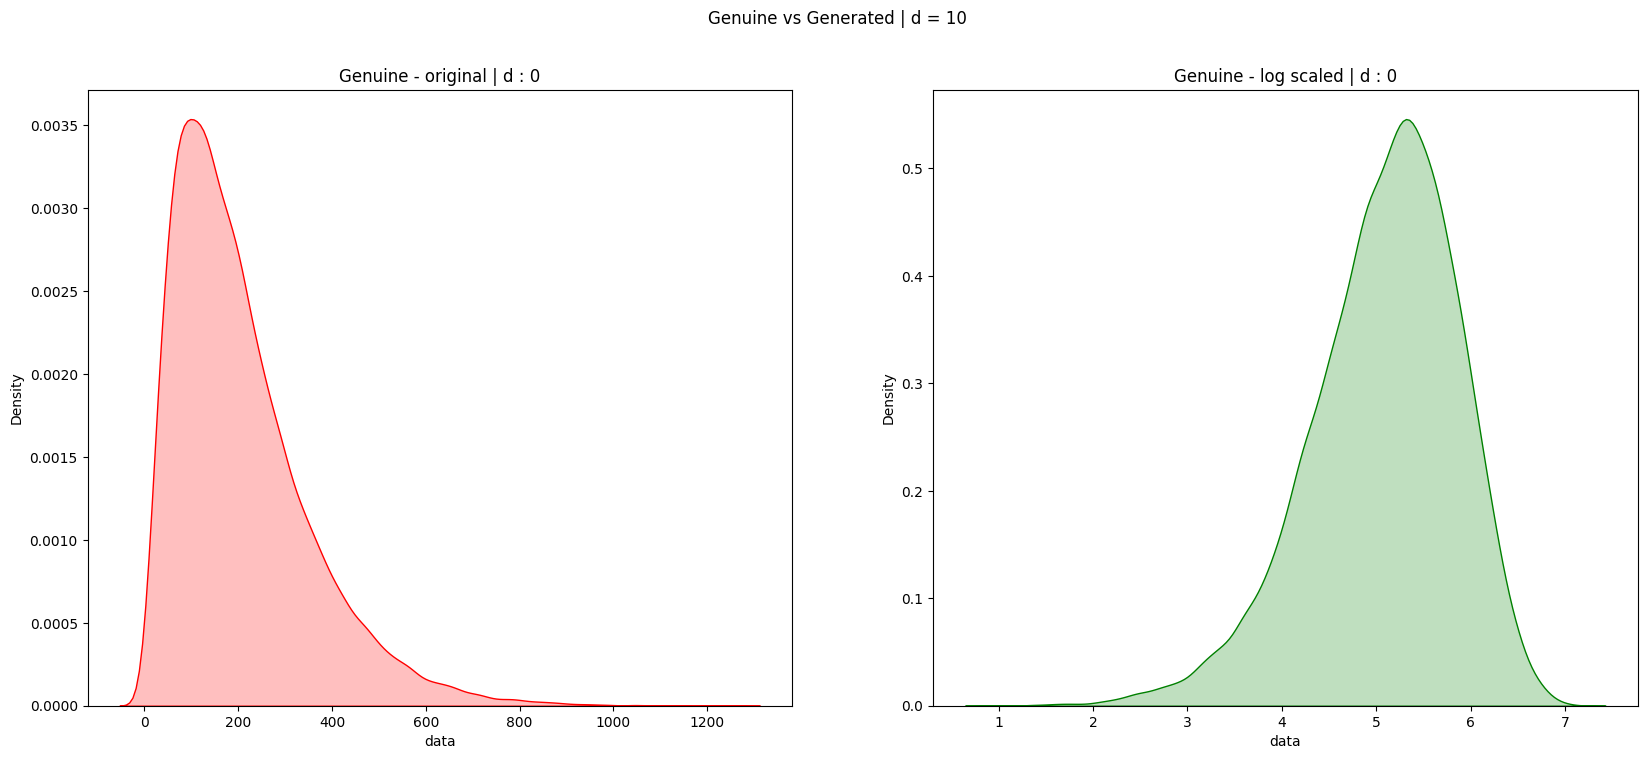

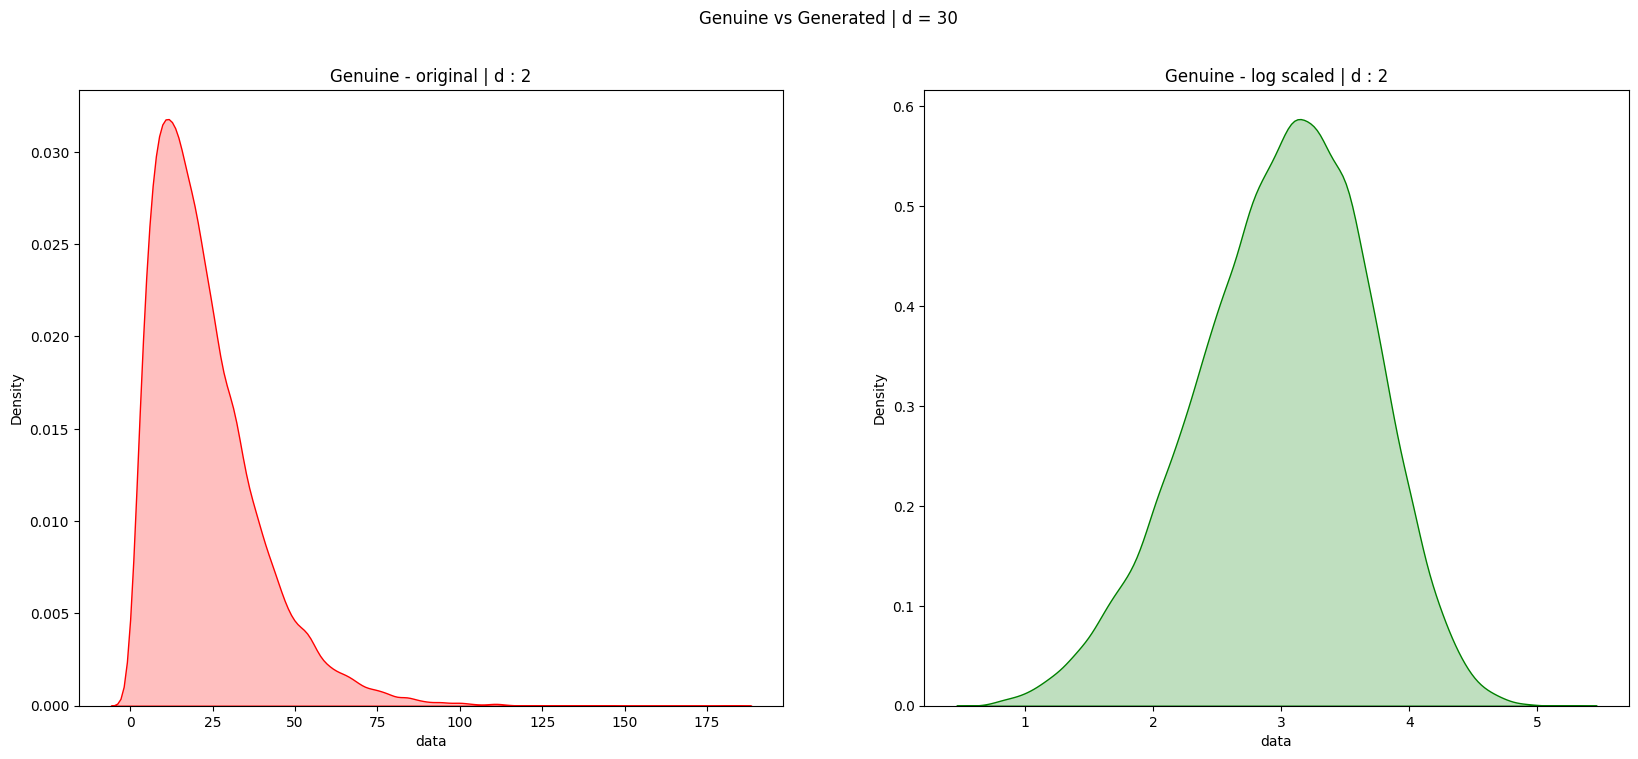

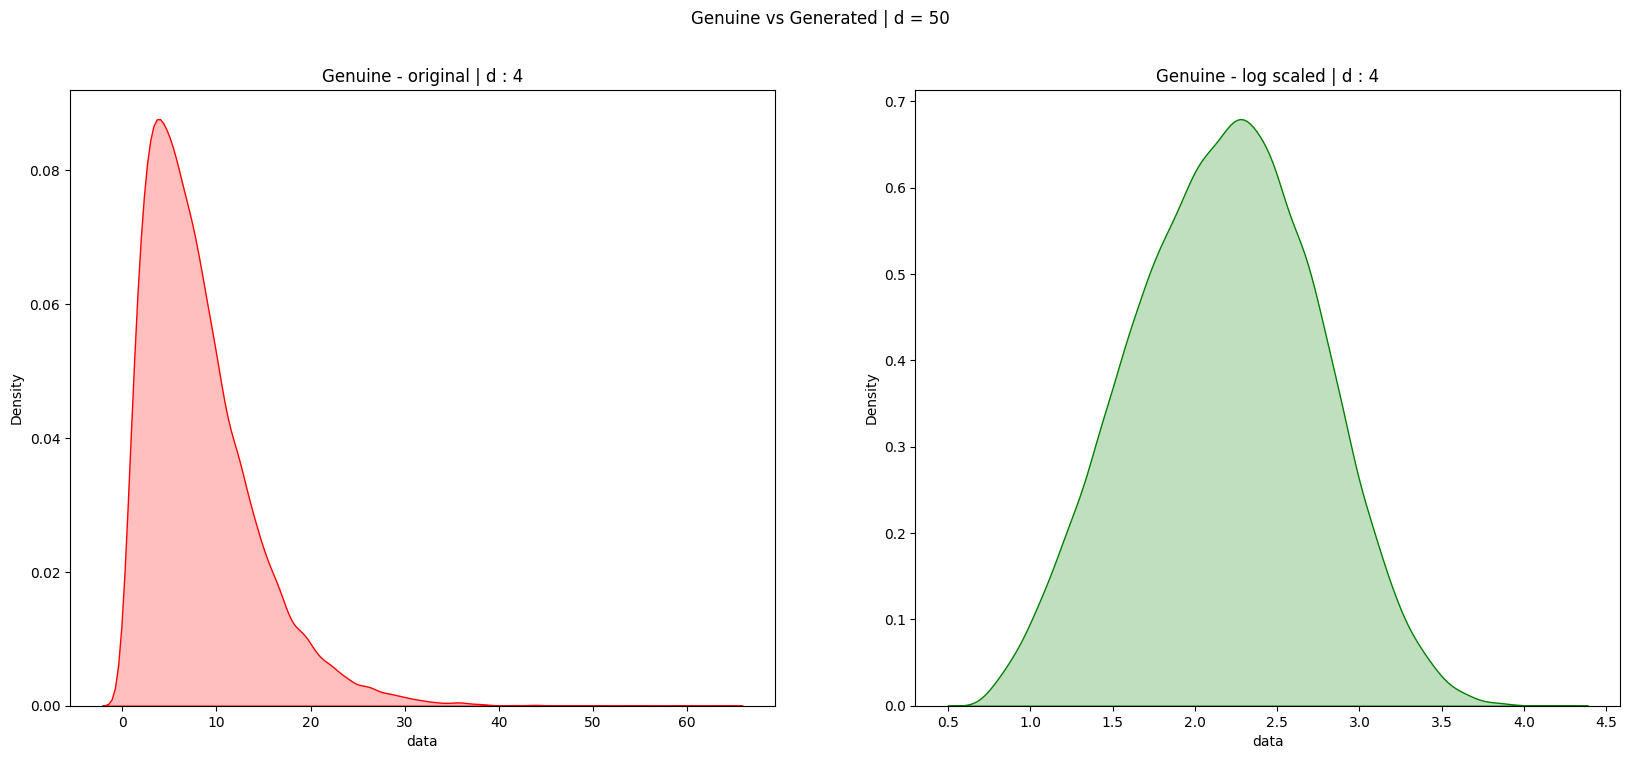

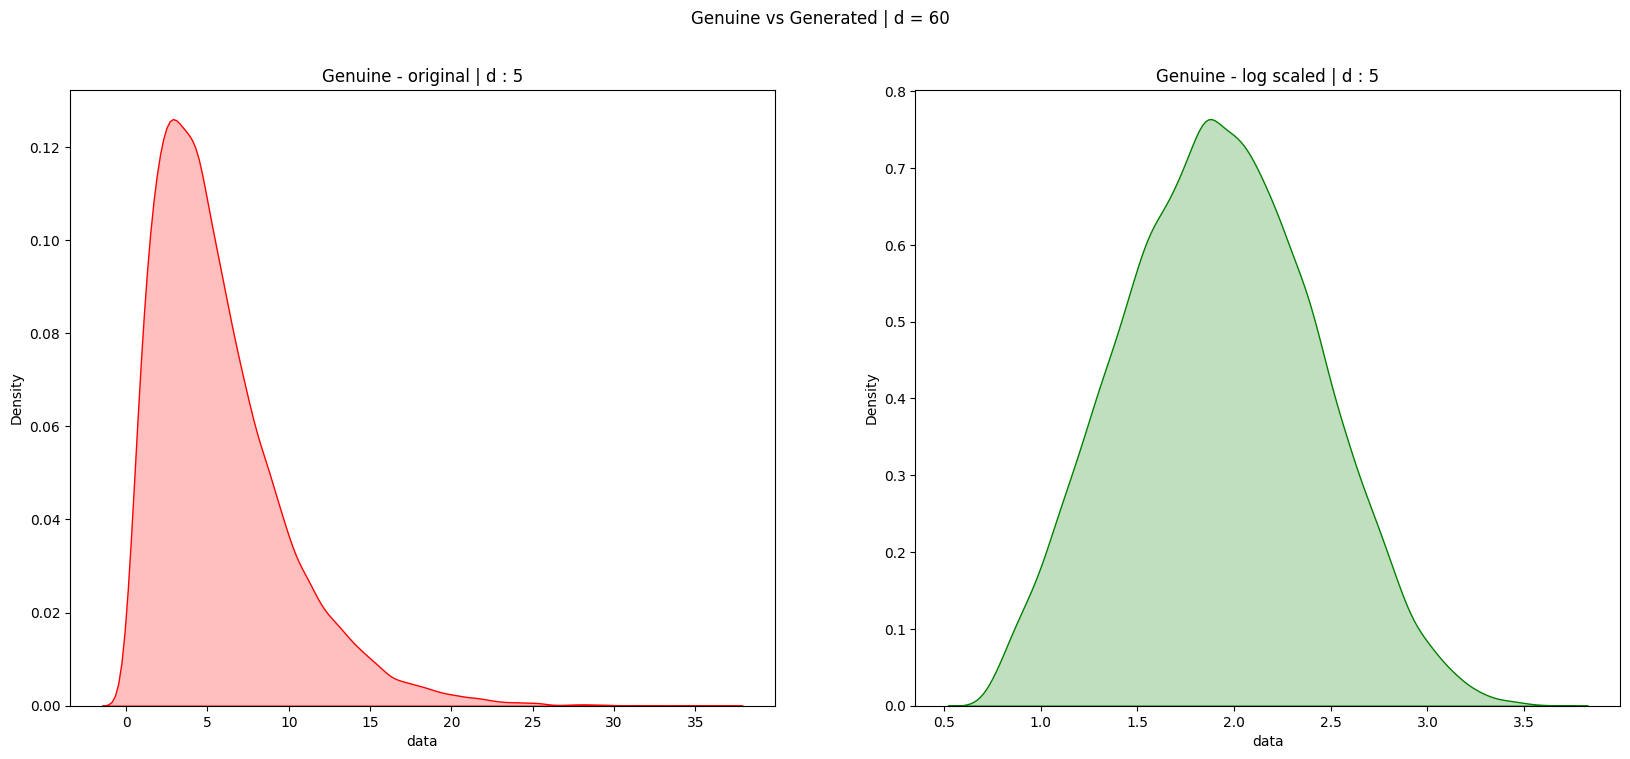

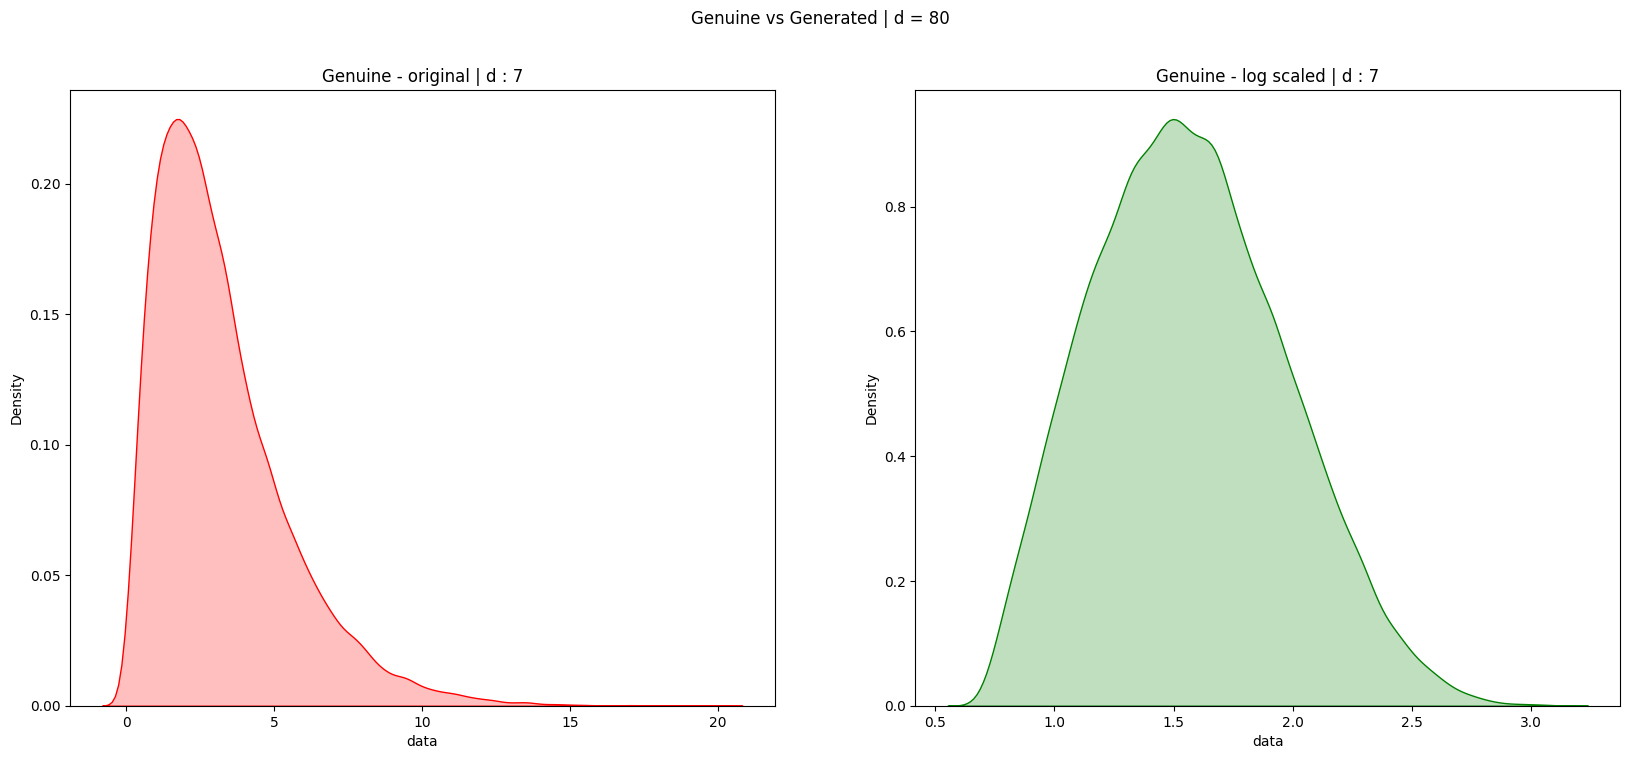

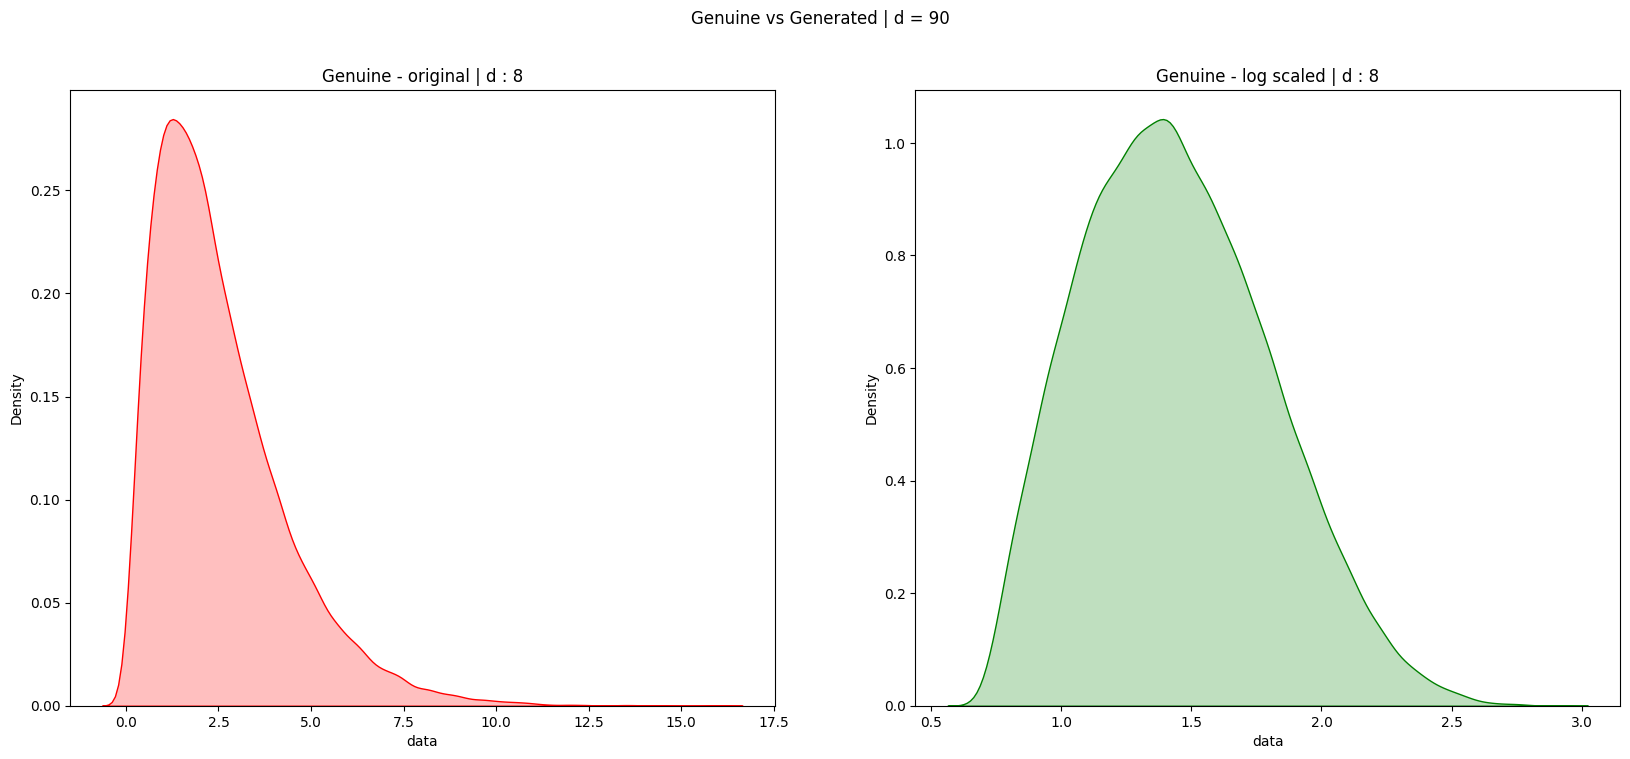

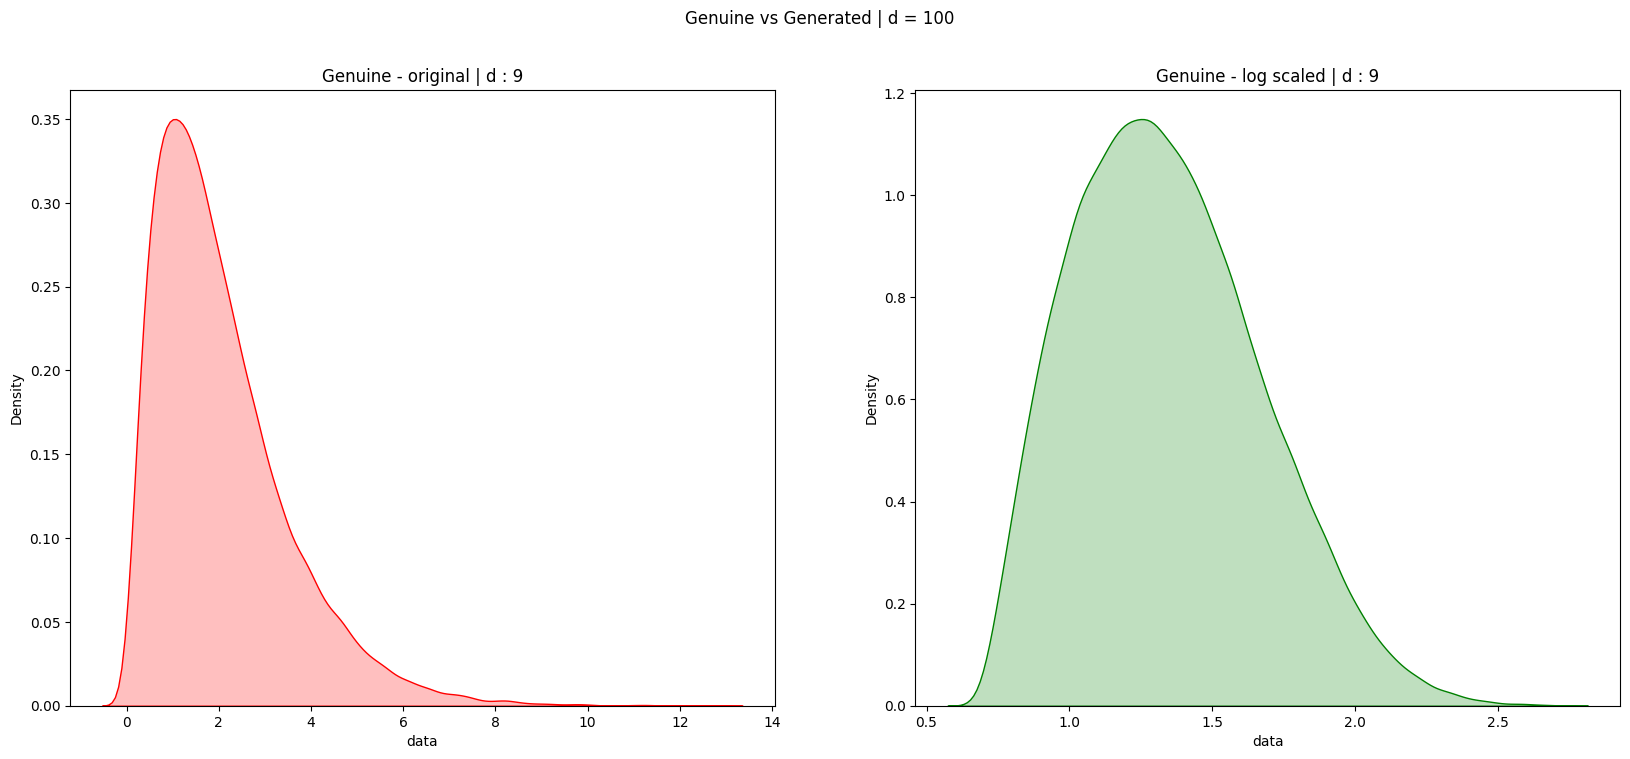

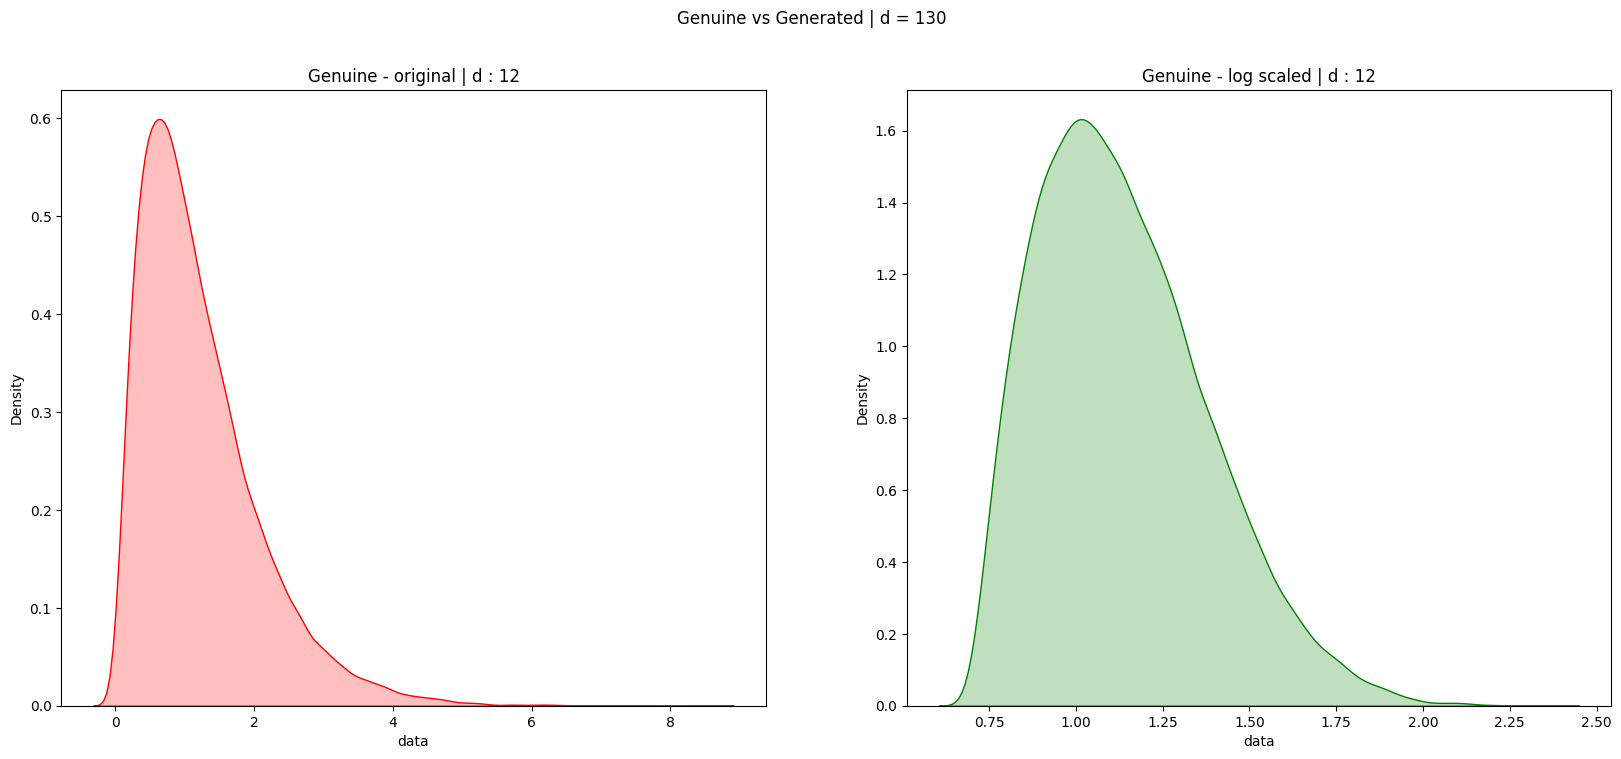

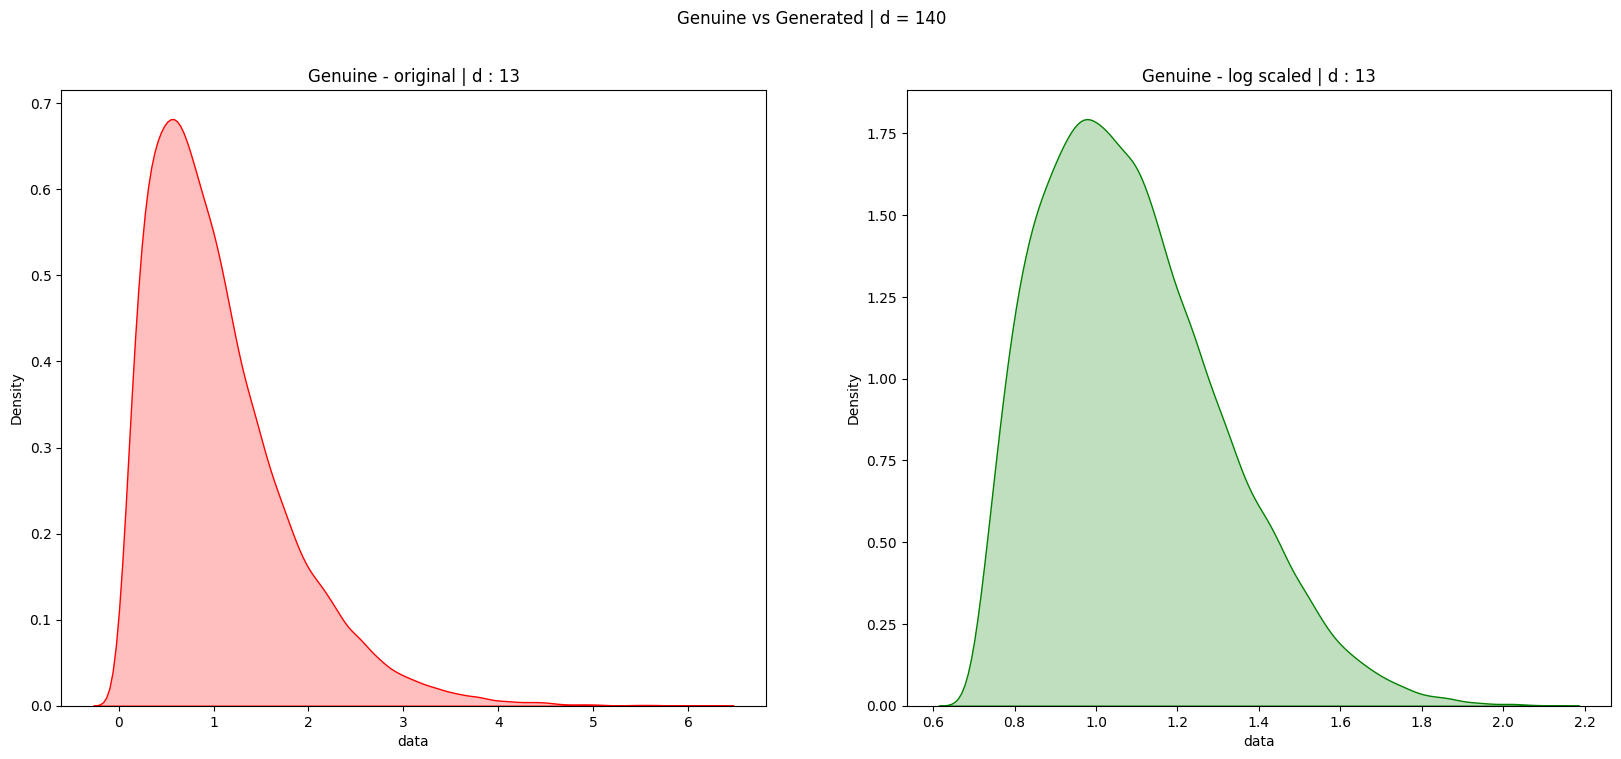

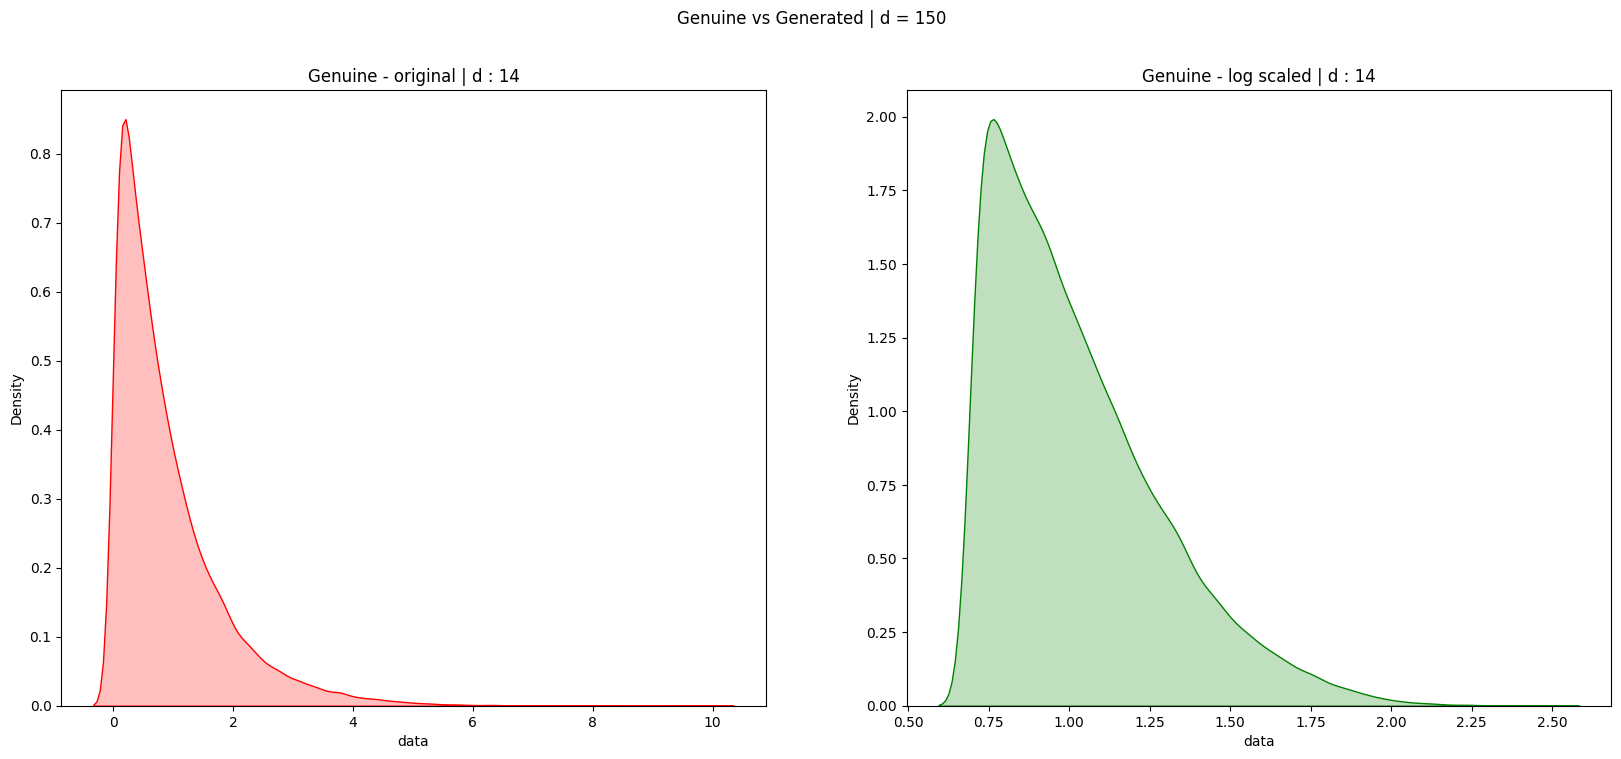

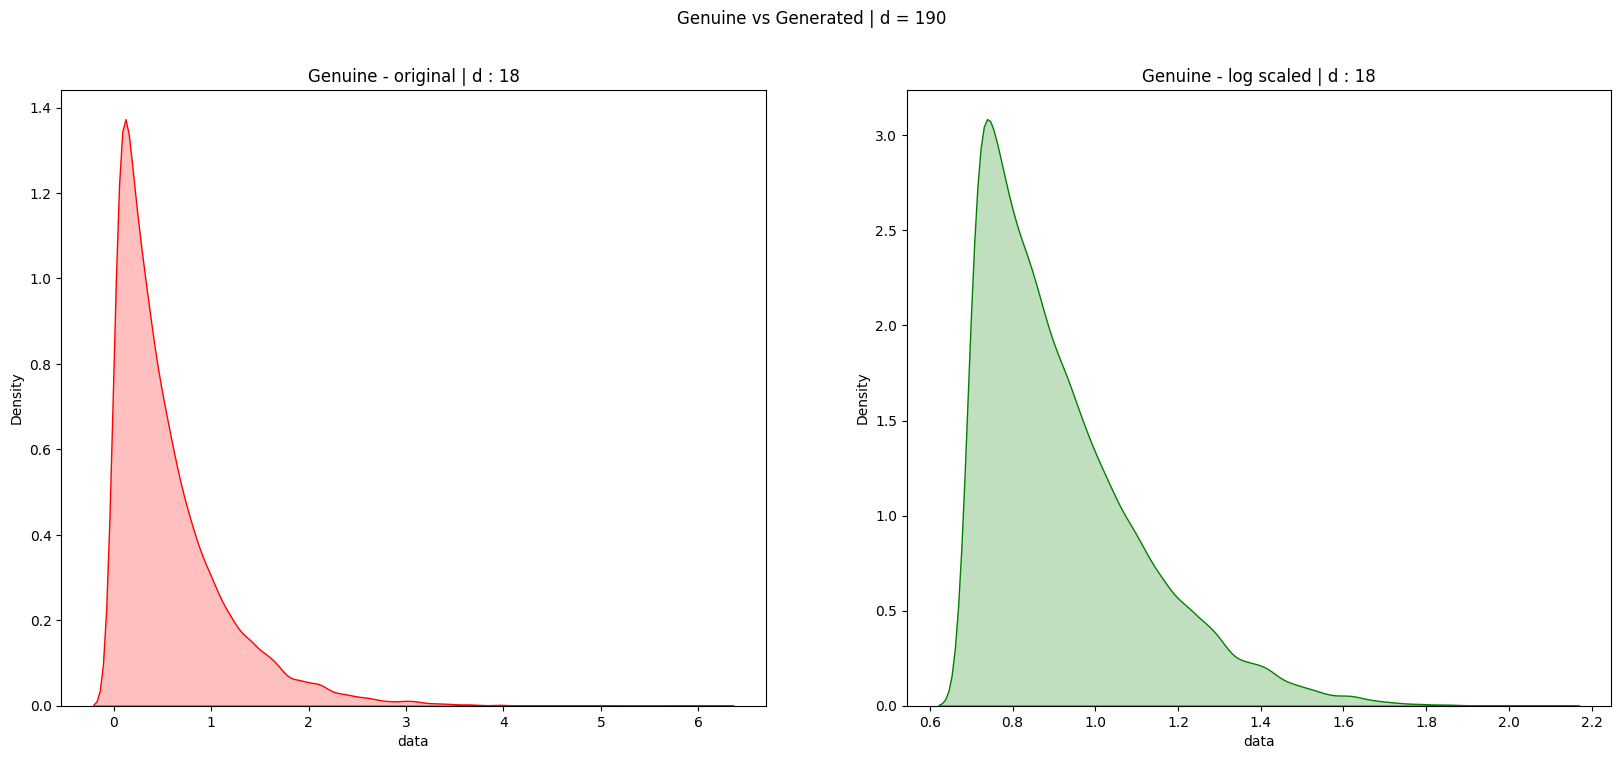

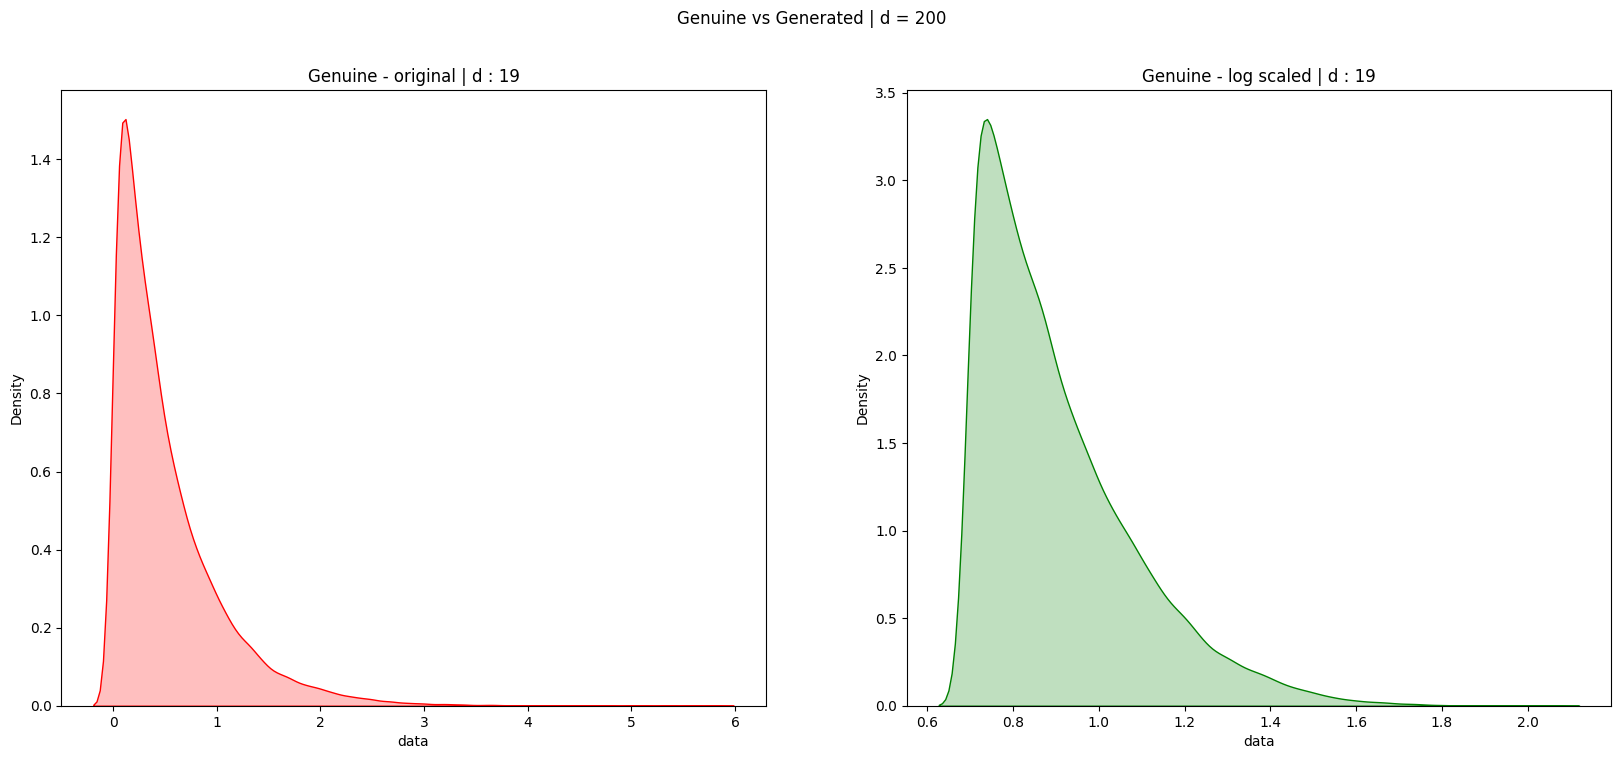

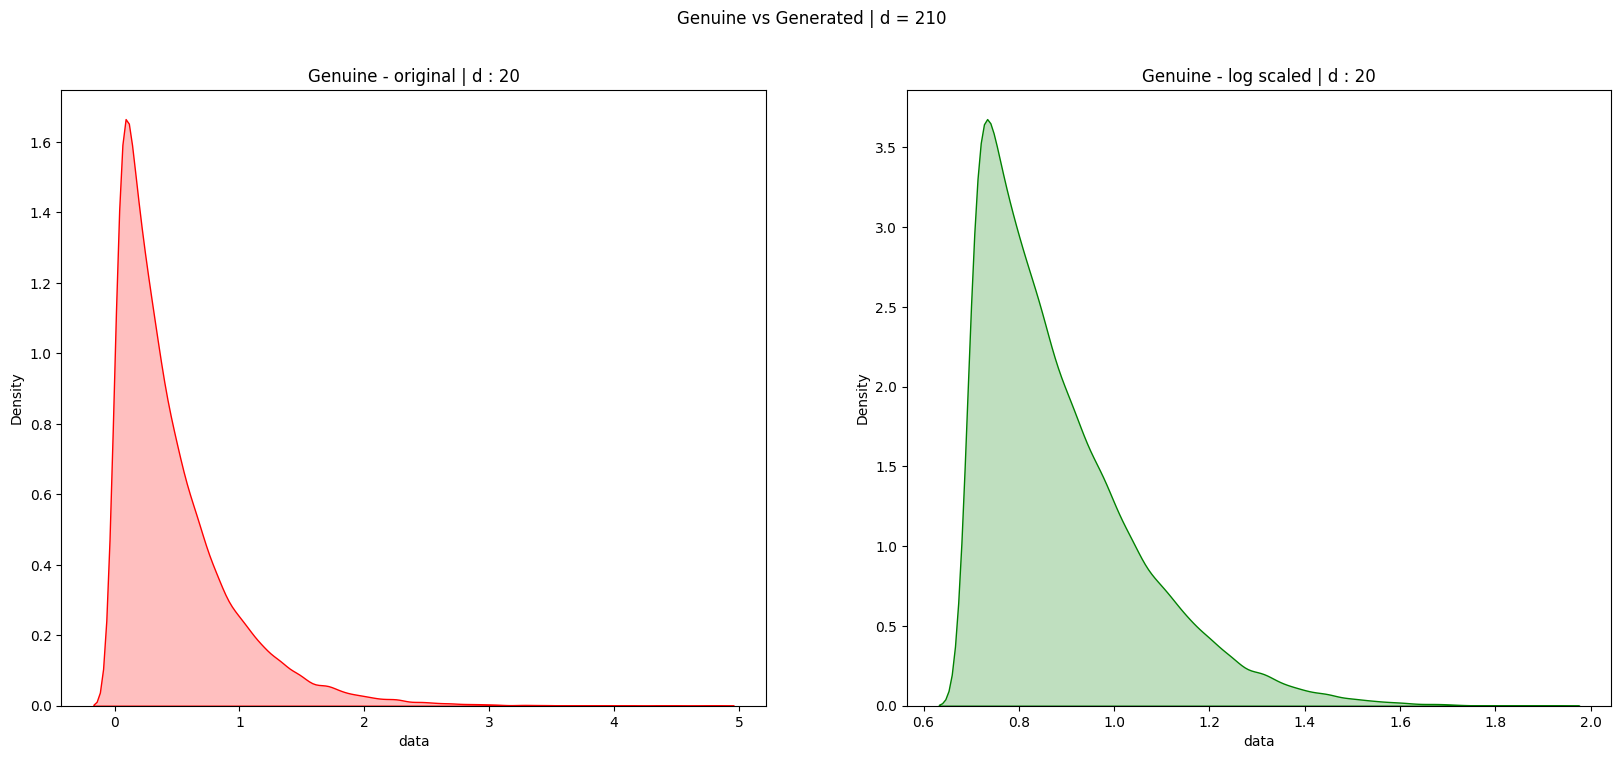

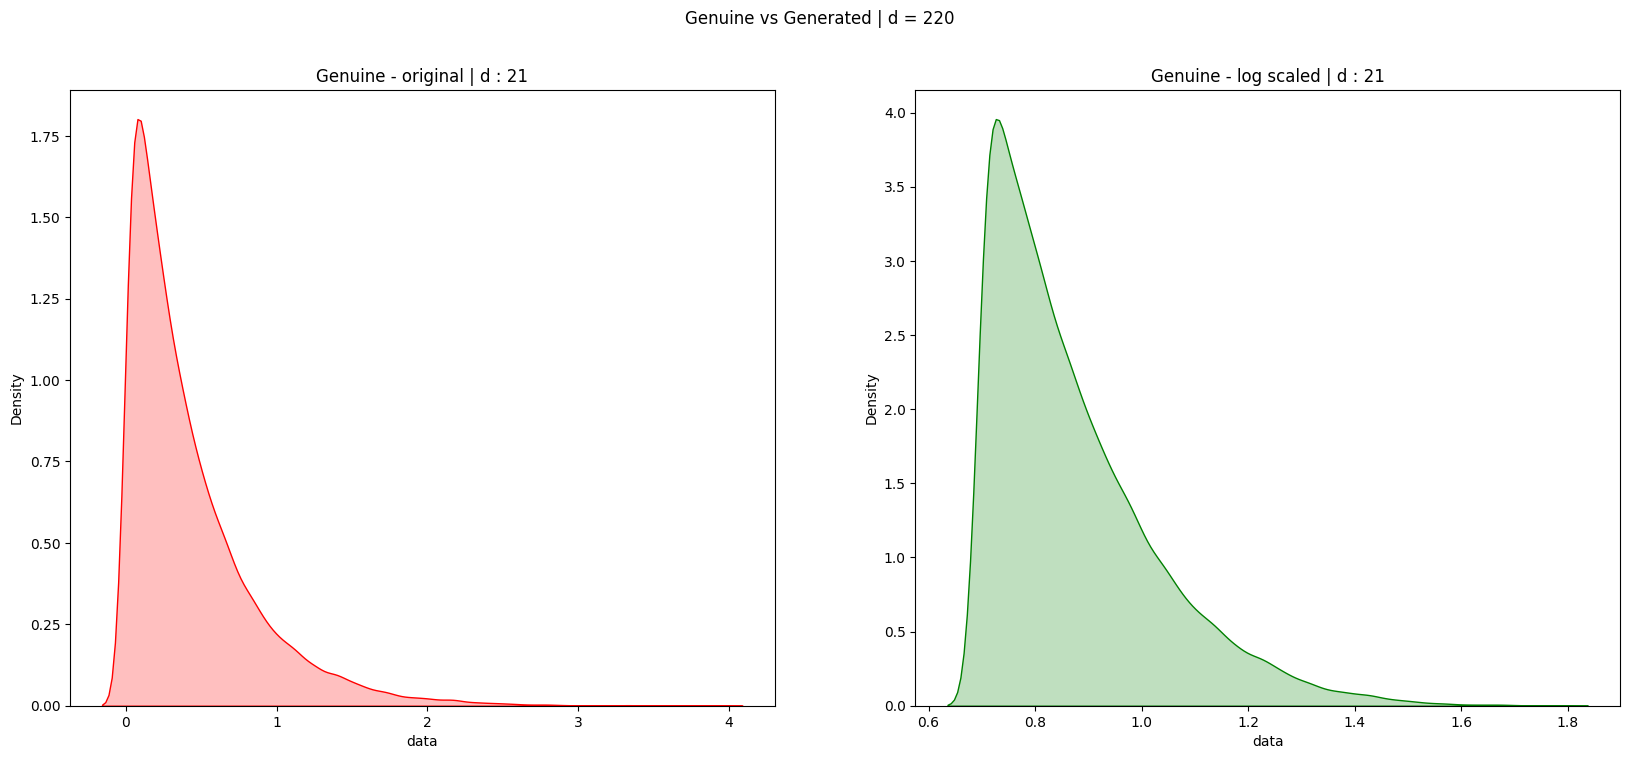

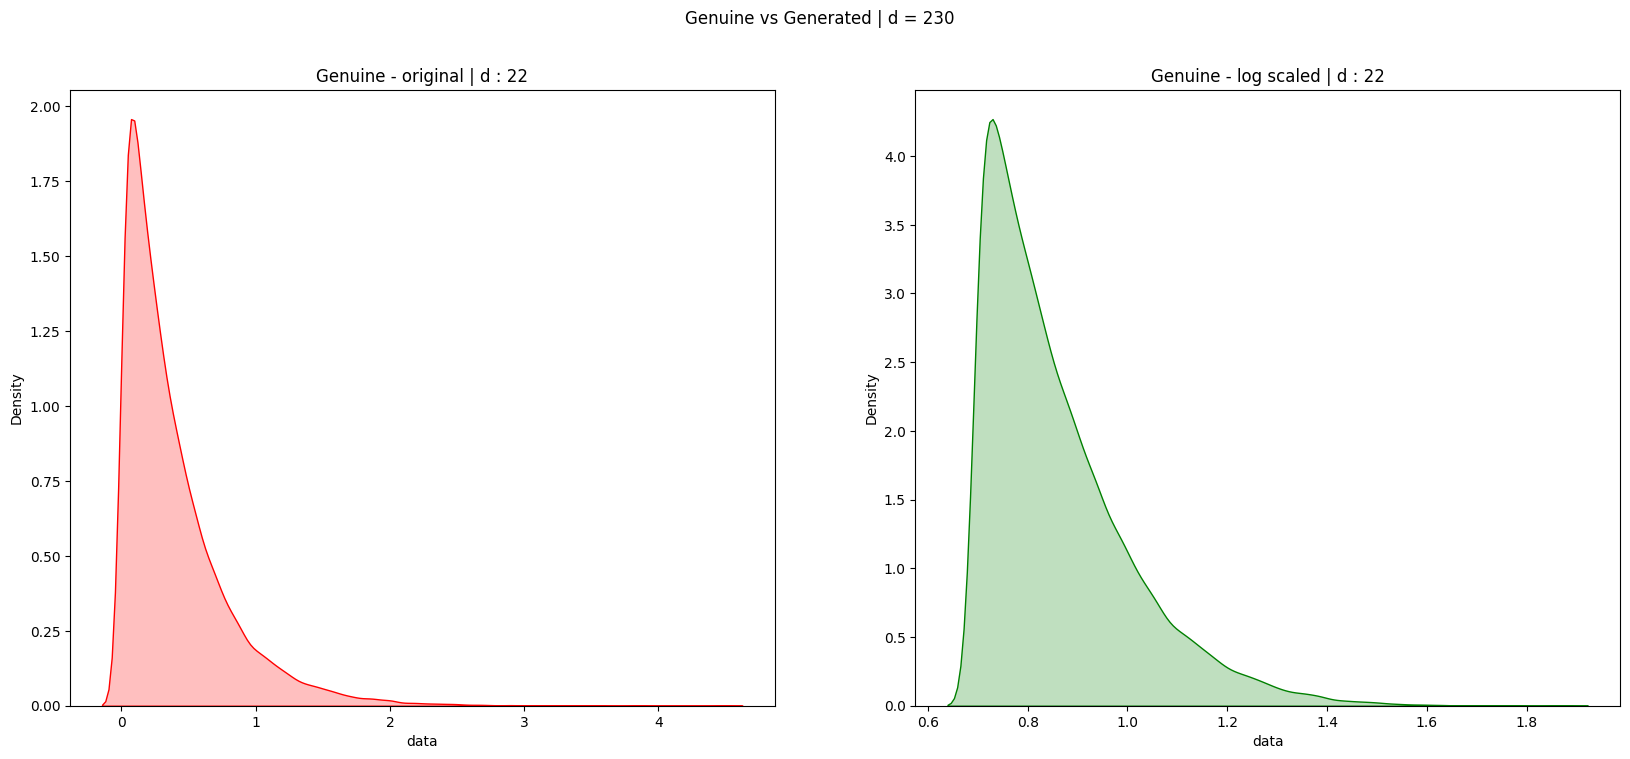

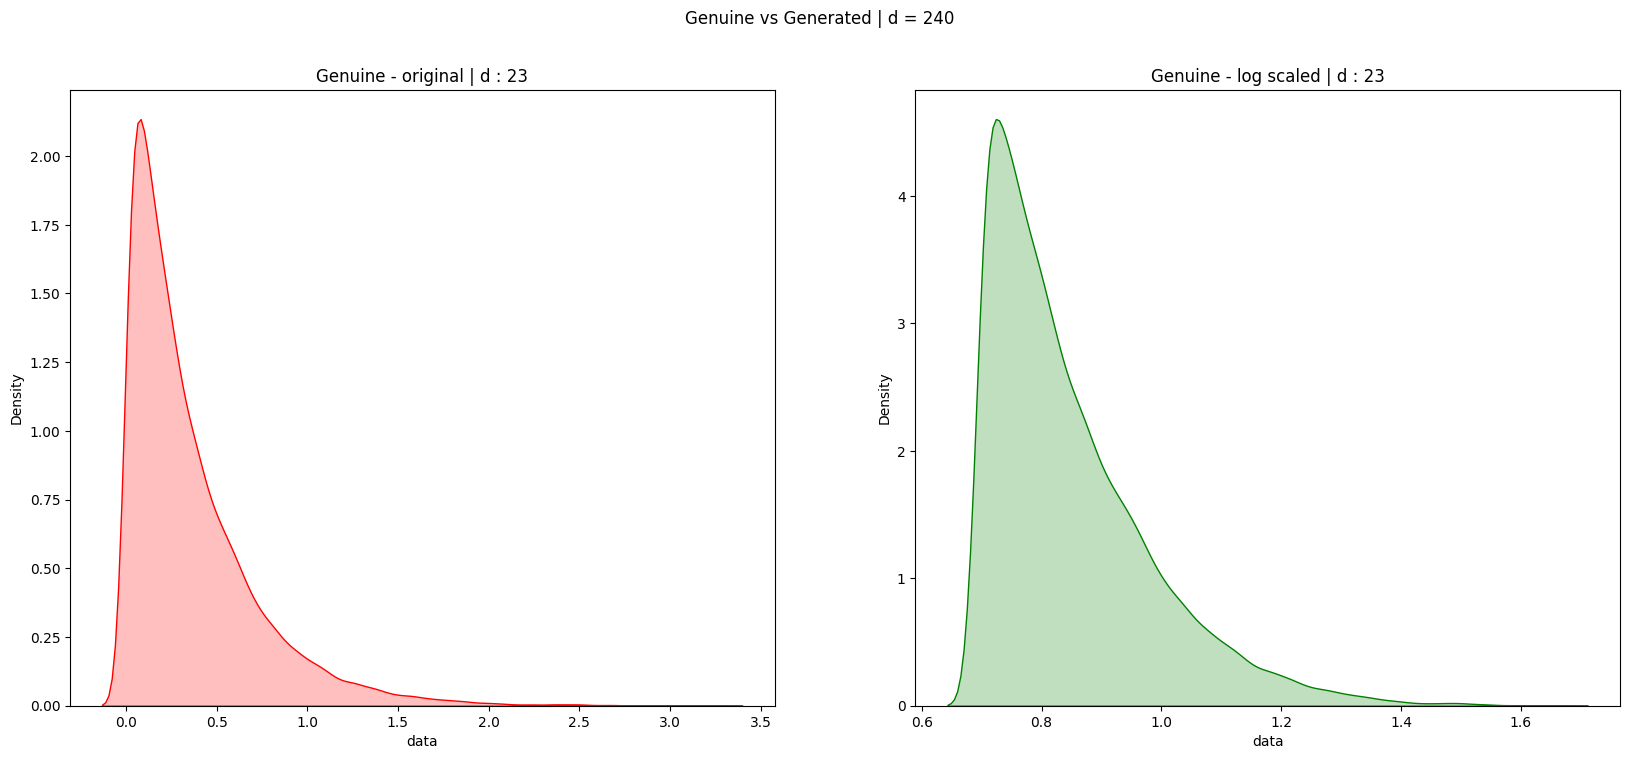

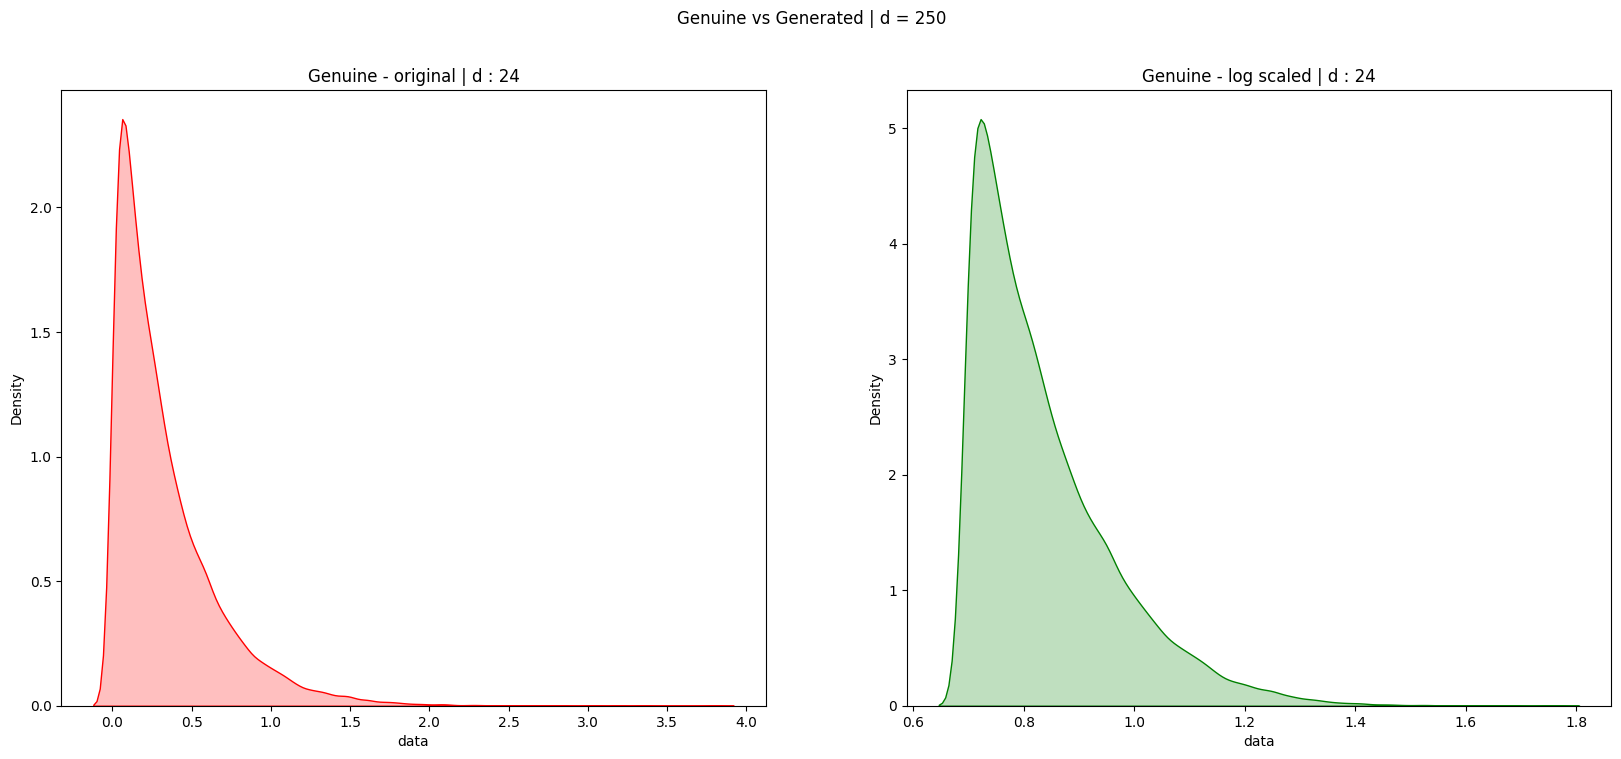

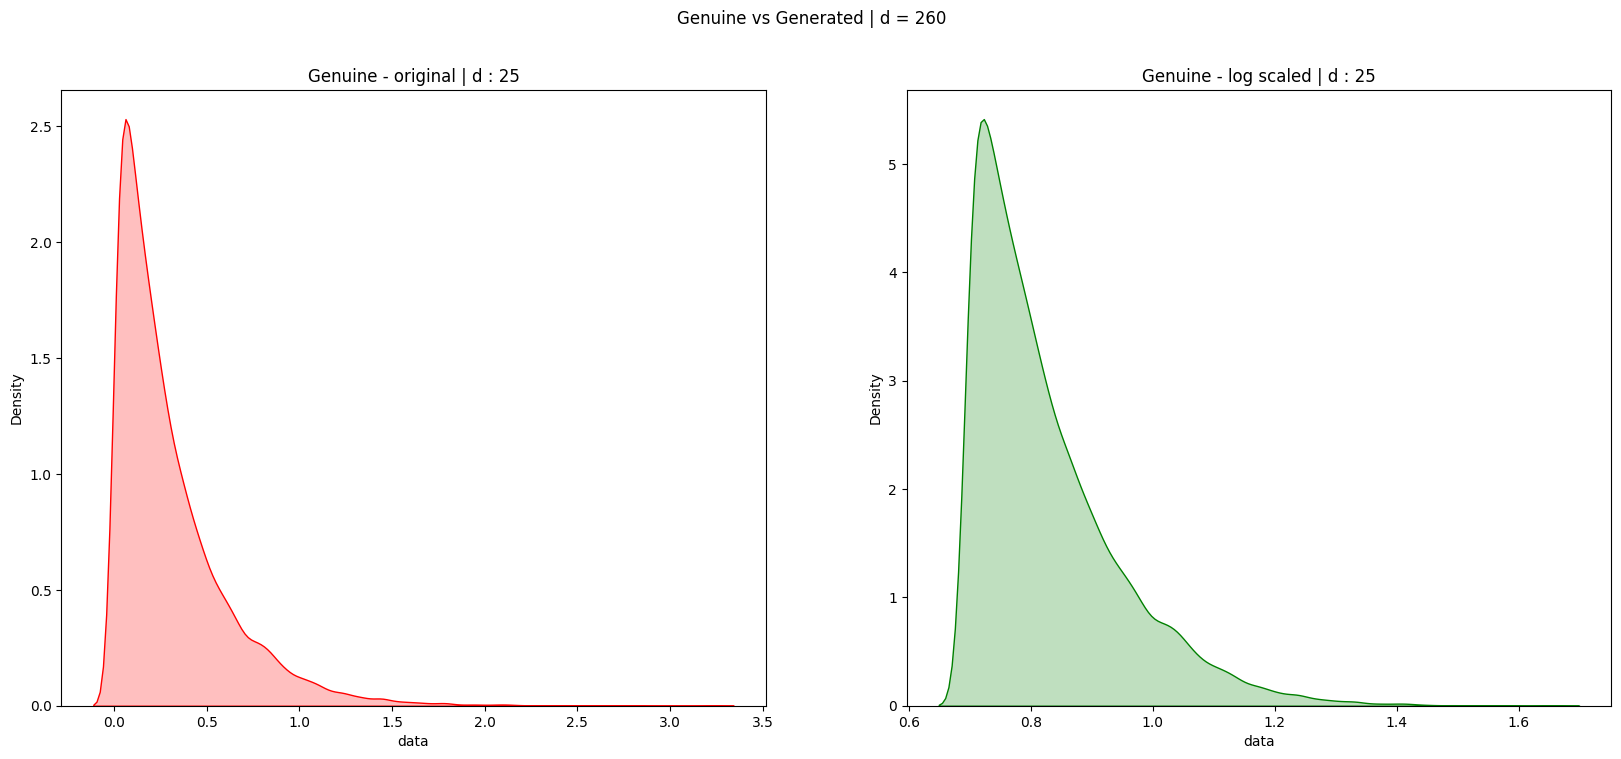

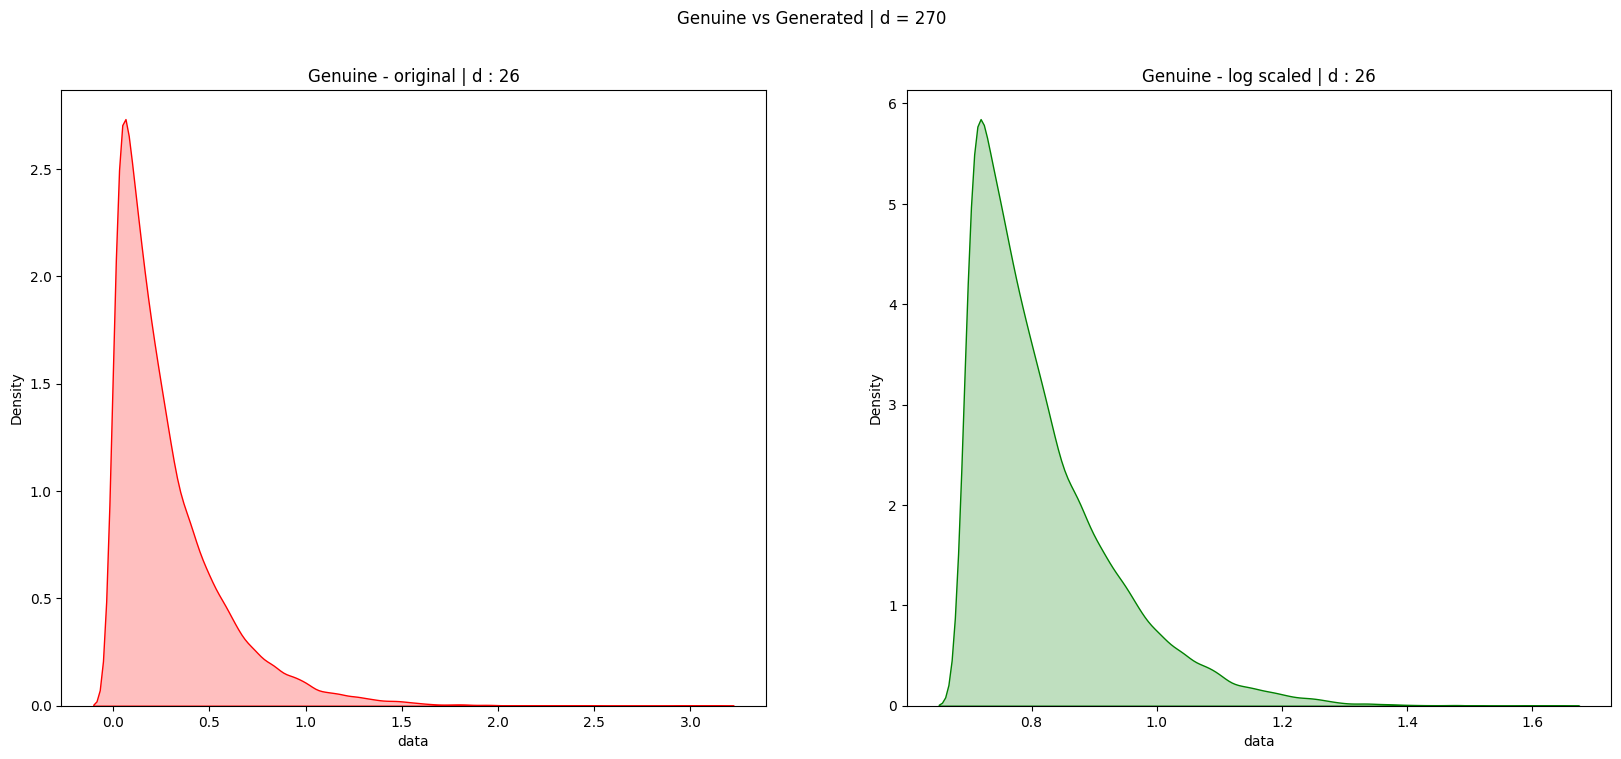

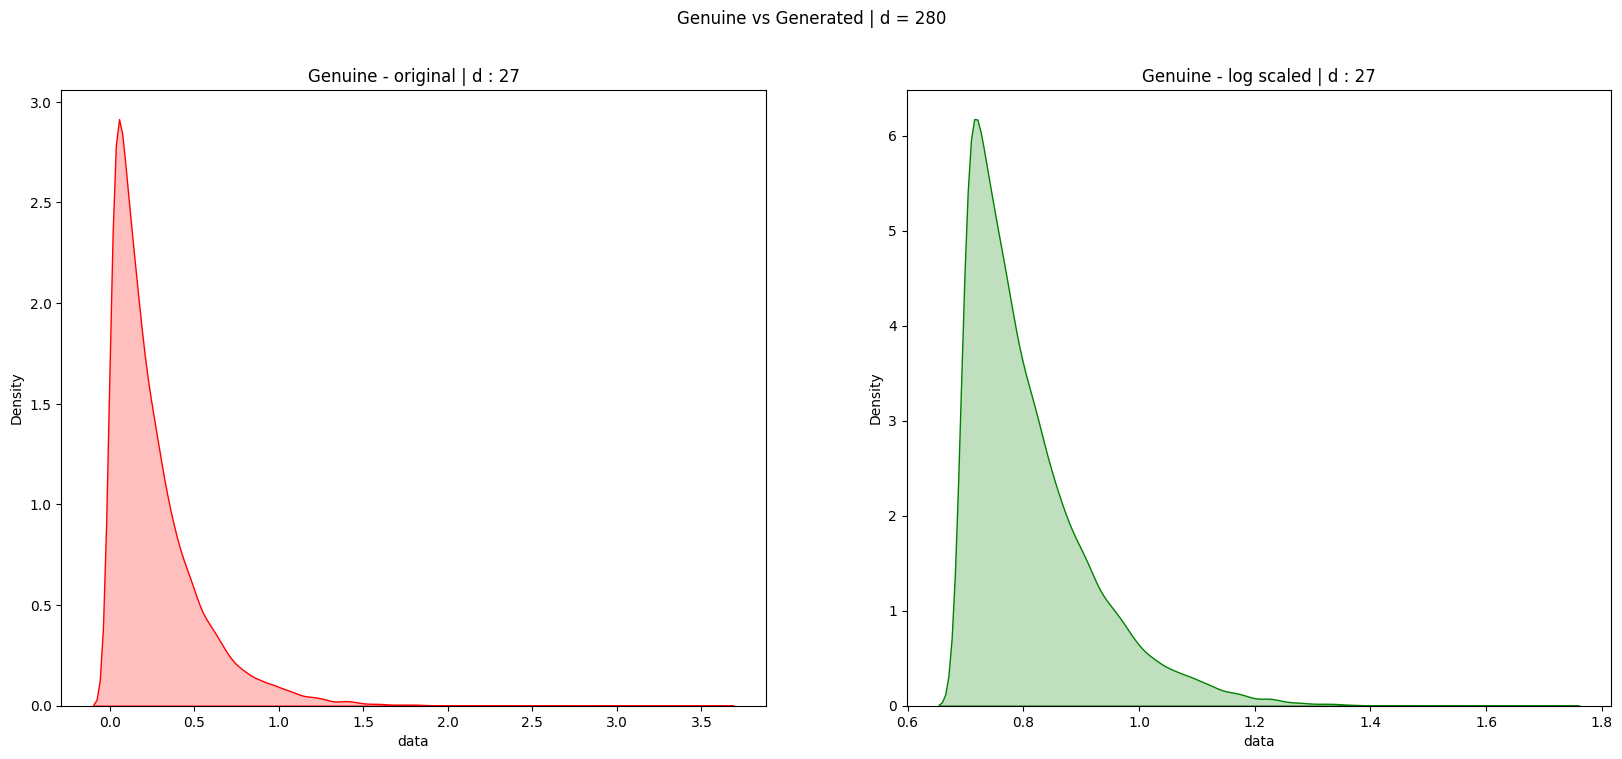

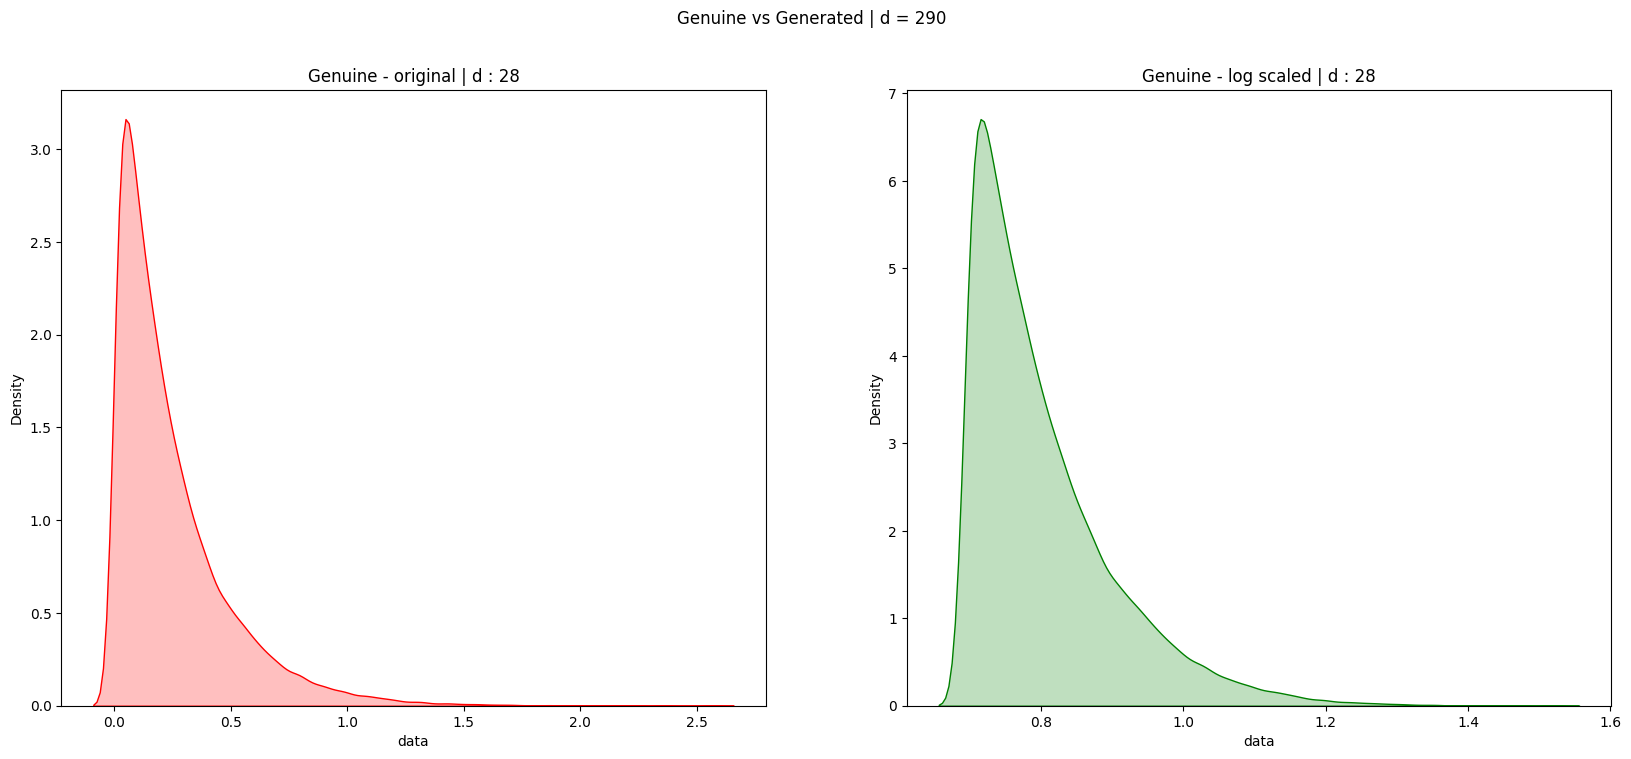

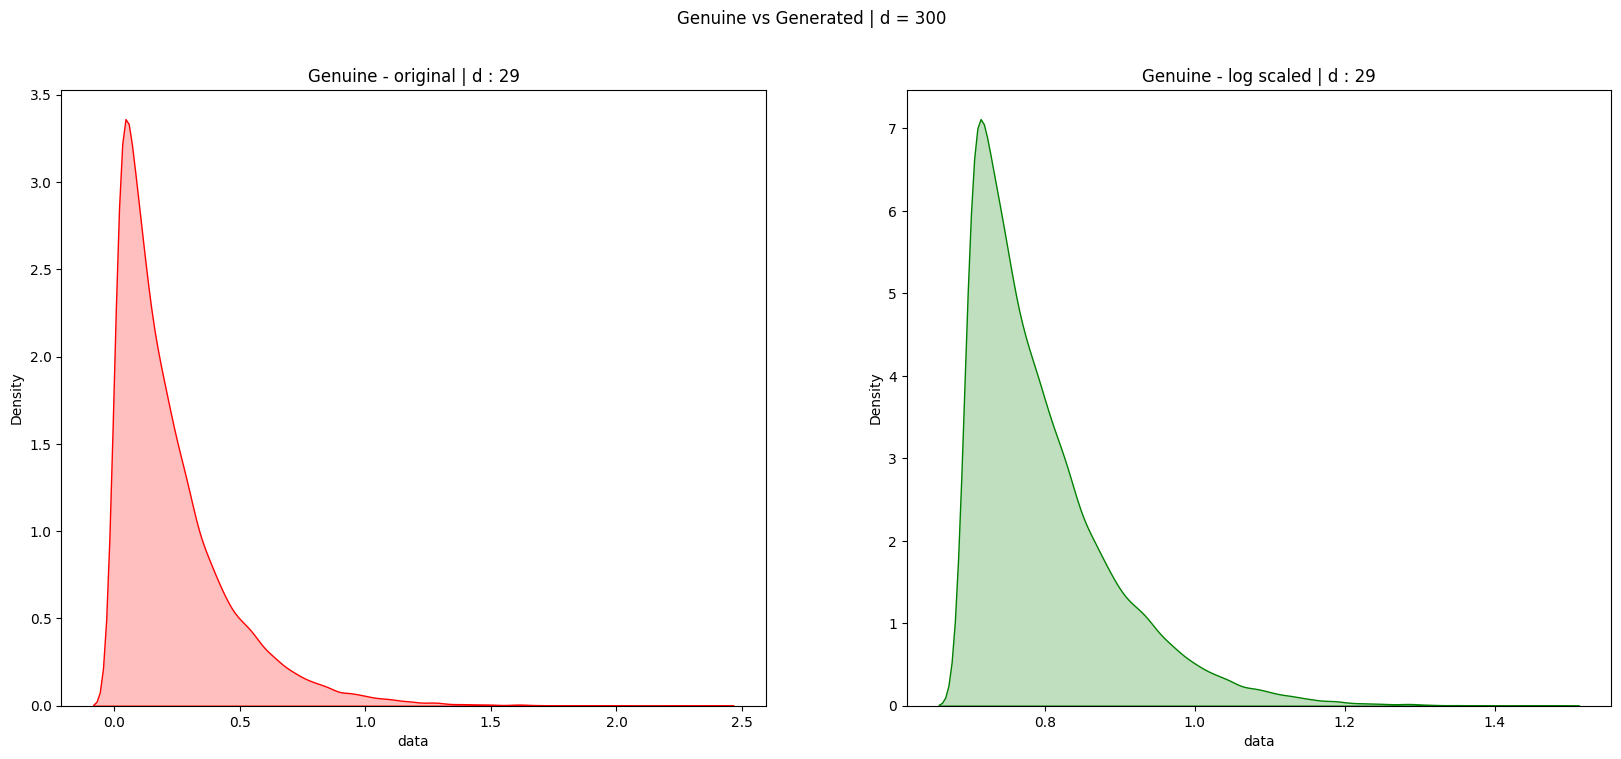

In [10]:
_d_array = np.arange(10, 301, 10, dtype=np.int32)
for i in range(len(df_genuine['d'].unique())):
    # Melt the data to long-form
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    sns.kdeplot(data=df_genuine[df_genuine['d'] == i], x='data', 
                fill=True, ax=ax1, color='red')
    ax1.set_title(f"Genuine - original | d : {i}")
    
    sns.kdeplot(data=df_genuine_log_scaled[df_genuine_log_scaled['d'] == i], 
                x='data', fill=True, ax=ax2, color='green')
    ax2.set_title(f"Genuine - log scaled | d : {i}")
    
    fig.suptitle(f"Genuine vs Generated | d = {_d_array[i]}")
    plt.show()

### Calculate the Ideal mean and var of the Nakagami

In [11]:
df_ideal_mean = pd.DataFrame(data=NakagamiV2Evaluator().validate_mean(), columns=['ideal_data'])
df_ideal_var = pd.DataFrame(data=NakagamiV2Evaluator().validate_var(), columns=['ideal_data'])

### Comparing Genuine Data and Ideal Data

#### Mean

In [12]:
df_mean_comp = pd.concat([df_genuine.groupby('d').mean(), df_ideal_mean], axis=1)
df_per_diff_mean_real = (((df_mean_comp['data'] - df_mean_comp['ideal_data']) / df_mean_comp['ideal_data']) * 100).round(2)
df_per_diff_mean_dict = {'per_diff%':df_per_diff_mean_real, }
df_mean_comp_final = pd.concat([df_mean_comp, pd.DataFrame(df_per_diff_mean_dict)], axis=1)
# df_mean_comp_final[df_mean_comp_final.columns[[0, 2, 4, 1, 3, 5]]]
df_mean_comp_final

data  ideal_data  per_diff%
0.0   205.634883  205.460011       0.09
1.0    51.485410   51.365003       0.23
2.0    22.762870   22.828890      -0.29
3.0    12.784014   12.841251      -0.45
4.0     8.231265    8.218400       0.16
5.0     5.735777    5.707223       0.50
6.0     4.211845    4.193061       0.45
7.0     3.202603    3.210313      -0.24
8.0     2.527766    2.536543      -0.35
9.0     2.054136    2.054600      -0.02
10.0    1.707596    1.698017       0.56
11.0    1.426658    1.426806      -0.01
12.0    1.216248    1.215740       0.04
13.0    1.050406    1.048265       0.20
14.0    0.901276    0.913156      -1.30
15.0    0.794230    0.802578      -1.04
16.0    0.718032    0.710934       1.00
17.0    0.637698    0.634136       0.56
18.0    0.567392    0.569141      -0.31
19.0    0.513802    0.513650       0.03
20.0    0.462810    0.465896      -0.66
21.0    0.426273    0.424504       0.42
22.0    0.390094    0.388393       0.44
23.0    0.357845    0.356701       0.32
24.0    0.328726    0.328736      -0.00
25.0    0.303745    0.303935      -0.06
26.0    0.280725    0.281838      -0.40
27.0    0.263265    0.262066       0.46
28.0    0.244032    0.244304      -0.11
29.0    0.229253    0.228289       0.42

### Var

In [13]:
df_var_comp = pd.concat([df_genuine.groupby('d').var(), df_ideal_var], axis=1)
df_per_diff_var_real = (((df_var_comp['data'] - df_var_comp['ideal_data']) / df_var_comp['ideal_data']) * 100).round(2)
df_per_diff_var_dict = {'per_diff%':df_per_diff_var_real, }
df_var_comp_final = pd.concat([df_var_comp, pd.DataFrame(df_per_diff_var_dict)], axis=1)
# df_mean_comp_final[df_mean_comp_final.columns[[0, 2, 4, 1, 3, 5]]]
df_var_comp_final

data    ideal_data  per_diff%
0.0   21101.105259  21106.908132      -0.03
1.0    1338.511240   1319.181758       1.47
2.0     261.266899    260.579113       0.26
3.0      80.031005     82.448860      -2.93
4.0      34.154668     33.771053       1.14
5.0      16.602122     16.286195       1.94
6.0       8.767099      8.790882      -0.27
7.0       5.103412      5.153054      -0.96
8.0       3.152510      3.217026      -2.01
9.0       2.111104      2.110691       0.02
10.0      1.481984      1.441630       2.80
11.0      1.006749      1.017887      -1.09
12.0      0.745887      0.739012       0.93
13.0      0.547690      0.549430      -0.32
14.0      0.813900      0.833853      -2.39
15.0      0.636981      0.644132      -1.11
16.0      0.516095      0.505428       2.11
17.0      0.405380      0.402128       0.81
18.0      0.326863      0.323922       0.91
19.0      0.266801      0.263836       1.12
20.0      0.211627      0.217059      -2.50
21.0      0.181839      0.180204       0.91
22.0      0.151683      0.150849       0.55
23.0      0.127587      0.127236       0.28
24.0      0.106856      0.108067      -1.12
25.0      0.091652      0.092376      -0.78
26.0      0.079244      0.079433      -0.24
27.0      0.069574      0.068679       1.30
28.0      0.060364      0.059685       1.14
29.0      0.052014      0.052116      -0.20

# AI modeling

In [14]:
import tensorflow as tf
from keras.layers import Input, Flatten, multiply, BatchNormalization, Dropout
from keras.layers import Dense, Embedding
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [15]:
class FNN_V2():
    def __init__(self):
        self.output_vec_len = 1
        self.embedding_output_len = 2
        self.rough_condition_dim = NakagamiV2().generate(1)[1].shape[1]
        self.condition_dim = self.embedding_output_len + (self.rough_condition_dim - 1) # length of r == (2 - 1)

        optimizer = Adam(learning_rate=5e-5)
        metrics_mse = tf.keras.metrics.MeanSquaredError()
        metrics_rmse = tf.keras.metrics.RootMeanSquaredError()
        # optimizer = RMSprop(learning_rate=0.00005)
        
        self.FNN = self.build_FNN()
        
        # self.FNN.compile(loss='mean_squared_error',
        self.FNN.compile(loss=self.rmse,
                        optimizer=optimizer,
                        metrics=[metrics_mse, metrics_rmse])

    def rmse(self, y_true, y_pred):
        error = y_true - y_pred    
        sqr_error = K.square(error)
        mean_sqr_error = K.mean(sqr_error)
        sqrt_mean_sqr_error = K.sqrt(mean_sqr_error)
        
        return sqrt_mean_sqr_error
 
    def build_FNN(self):
        
        fnn_input = Input(shape=(self.rough_condition_dim), name="fnn_input")
        
        label_d = tf.expand_dims(fnn_input[:, 0], axis=1)
        label_r = tf.expand_dims(fnn_input[:, 1], axis=1)
        
        label_embedding = Embedding(NakagamiV2().d_len, self.embedding_output_len, input_length=label_d.shape[1])(label_d)
        label_embedding = Flatten()(label_embedding)
        
        label_combined = tf.concat([label_embedding, label_r], 1)
        
        x = Dense(512, activation='gelu')(label_combined)
        x = BatchNormalization(momentum=0.8)(x)
        
        x = Dense(512, activation='gelu')(x)
        x = BatchNormalization(momentum=0.8)(x)
        
        x = Dense(512, activation='gelu')(x)
        x = BatchNormalization(momentum=0.8)(x)
        
        x = Dense(512, activation='gelu')(x)
        x = BatchNormalization(momentum=0.8)(x)

        x = Dense(512, activation='gelu')(x)
        x = BatchNormalization(momentum=0.8)(x)

        x = Dense(512, activation='gelu')(x)
        x = BatchNormalization(momentum=0.8)(x)
        
        fnn_output = Dense(self.output_vec_len)(x)

        fnn_model = Model(fnn_input, fnn_output, name='fnn_v3')
        fnn_model.summary()
        
        return fnn_model

    def train(self, epochs:int, version:str, short_cut:str, batch_size:int=32, verbose:int=2):

        # Training data
        X_train = rough_condition_for_ai
        y_train = data_for_ai_log_transformed
            
        # Callback Functions
        monitoring = 'val_loss'
        rlr = ReduceLROnPlateau(monitor=monitoring, min_lr=1e-6)

        dir_model_save = short_cut + "/FNN-{epoch:04d}.h5"
        cp = ModelCheckpoint(dir_model_save, monitor=monitoring, 
                                     verbose=verbose, mode='min')

        # Create a CSVLogger callback to save the training log to a CSV file
        log_filename = 'training_log.csv'  # Specify the file name
        cl = CSVLogger(f"{short_cut}/{log_filename}", append=True) 

        callbacks = [cl, cp, rlr]
        
        if os.path.exists(short_cut):
            print(f'Directory "{version}" is already existed!!')
            return None
        
        os.makedirs(short_cut, exist_ok=True)
        
        history = self.FNN.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                              shuffle=True, validation_split=0.2, callbacks=callbacks) # tried 0.5

        
        # Plot training loss and validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{short_cut}/loss_graph.png")
        plt.show()
        
        return history
        
        

## Train

In [16]:
epochs = 500
version = "FNN_rmse_e2"
nakagami_version = "Ap2"
my_short_cut = f"/home/ylee/wts2024_git/{nakagami_version}/{version}"

fnn = FNN_V2()
history = fnn.train(epochs=epochs, version=version, short_cut=my_short_cut)

Model: "fnn_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fnn_input (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None,)             0           ['fnn_input[0][0]']              
 ingOpLambda)                                                                                     
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 1)            0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                                
                                                                                             

2023-12-10 00:57:30.222961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22287 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:17:00.0, compute capability: 8.0


In [17]:
print(f"Model version : {version} Done")

Model version : FNN_rmse_e2 Done


## Calculate ScaledPE for the entire models

In [19]:
import sys
import os
import importlib
sys.path.append('/.')

import model_eval_git
importlib.reload(model_eval_git)

df_comp_result = model_eval_git.get_the_best_model(class_NakagamiV2=NakagamiV2(), target_model_dir=my_short_cut, 
                                               target_df_ideal_mean=df_ideal_mean, target_df_ideal_var=df_ideal_var,
                                               custom_metric={'rmse': FNN_V2().rmse}, is_noise=con.noise)

Model: "fnn_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fnn_input (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None,)             0           ['fnn_input[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, 1)            0           ['tf.__operators__.getitem_2[0][0
                                                                 ]']                              
                                                                                             

In [20]:
df_comp_result = pd.read_csv(f"{my_short_cut}/info_all_models.csv")
df_comp_result

epoch   mean_avg    var_avg
0      1.0  35.685333  33.569333
1      2.0  24.451333  17.802000
2      3.0  23.429000  11.176667
3      4.0   5.474667  17.553333
4      5.0  17.959333  19.443333
..     ...        ...        ...
495  496.0  41.972667  14.481333
496  497.0  68.243667  15.205667
497  498.0   6.706000  20.500000
498  499.0  14.404667   6.639333
499  500.0  15.730667   4.268000

[500 rows x 3 columns]

In [21]:
ratio_mean_avg = 0.3
ratio_var_avg = 1 - ratio_mean_avg
df_comp_result['scaled_weight'] = (df_comp_result['mean_avg']*ratio_mean_avg + df_comp_result['var_avg']*ratio_var_avg)/2

In [22]:
df_comp_result.sort_values(by='mean_avg', ascending=True).head(10)

epoch  mean_avg    var_avg  scaled_weight
131  132.0  4.134000  11.509333       4.648367
412  413.0  4.323667  14.834667       5.840683
329  330.0  4.426000  15.943333       6.244067
434  435.0  4.511667  19.106667       7.364083
420  421.0  4.635333  15.712333       6.194617
71    72.0  4.657333  10.732667       4.455033
352  353.0  4.711667  13.078000       5.284050
118  119.0  4.725000  10.796667       4.487583
47    48.0  5.056000  16.322000       6.471100
266  267.0  5.099333  16.528667       6.549933

In [23]:
df_comp_result.sort_values(by='var_avg', ascending=True).head(10)

epoch   mean_avg   var_avg  scaled_weight
319  320.0  49.971000  2.758667       8.461183
63    64.0  36.911000  3.155667       6.641133
383  384.0  25.697667  3.282333       5.003467
467  468.0  35.588667  3.291667       6.490383
440  441.0  32.860667  3.427333       6.128667
435  436.0  41.268667  3.488667       7.411333
196  197.0  39.411000  3.527000       7.146100
486  487.0  42.266333  3.545000       7.580700
365  366.0  35.905000  3.569667       6.635133
228  229.0  33.193333  3.606667       6.241333

In [24]:
df_comp_result.sort_values(by='scaled_weight', ascending=True).head(10)

epoch   mean_avg   var_avg  scaled_weight
315  316.0   6.619333  4.179000       2.455550
132  133.0   6.562000  5.957000       3.069250
119  120.0   7.783333  6.512667       3.446933
185  186.0   9.177333  6.188000       3.542400
122  123.0   8.371333  7.377333       3.837767
250  251.0   8.133333  7.520000       3.852000
499  500.0  15.730667  4.268000       3.853400
68    69.0  11.980333  5.895333       3.860417
25    26.0  14.137000  4.975000       3.861800
141  142.0   6.088000  8.451333       3.871167

In [25]:
# # if mse
# loaded_model = tf.keras.models.load_model(f'{my_short_cut}/FNN-0322.h5') 

# if rmse
loaded_model = tf.keras.models.load_model(f'{my_short_cut}/FNN-0316.h5', custom_objects={'rmse': FNN_V2().rmse})

Model: "fnn_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fnn_input (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None,)             0           ['fnn_input[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.expand_dims_4 (TFOpLambda)  (None, 1)            0           ['tf.__operators__.getitem_4[0][0
                                                                 ]']                              
                                                                                             

## Evaluation

### Generated Data

In [26]:
data_size = 100000
nakagami_signal, nakagami_condition, nagakami_indices = con.generate(data_size)

In [27]:
conditional_distribution_index_value = model_eval_git.get_conditional_distribution_index_value(loaded_model, nakagami_condition, nagakami_indices)

 141/3125 [>.............................] - ETA: 3s

2023-12-10 00:57:48.234118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3125/3125 [==============================] - 4s 1ms/step


In [28]:
df_generated_log_scaled_eval = pd.DataFrame(conditional_distribution_index_value.numpy(), columns=['data', 'd', 'r'])
df_generated_log_scaled_eval.head()

data     d         r
0  1.206375  13.0  0.724528
1  0.790464  18.0  0.269023
2  0.857254  20.0  0.491820
3  0.945035  16.0  0.530306
4  1.230786   6.0  0.151977

### Genuine Data

In [29]:
df_genuine_eval = pd.DataFrame(np.concatenate((nakagami_signal, nagakami_indices, np.expand_dims(nakagami_condition[:, 1],axis=1)), axis=1) , columns=['data', 'd', 'r'])
df_genuine_eval

data     d         r
0      1.341073  13.0  0.724528
1      0.178354  18.0  0.269023
2      0.315373  20.0  0.491819
3      0.537234  16.0  0.530306
4      1.444426   6.0  0.151977
...         ...   ...       ...
99995  0.846722   8.0  0.144631
99996  0.497846  25.0  0.805632
99997  0.178868  26.0  0.469878
99998  3.076329  11.0  0.928795
99999  1.742517   8.0  0.399134

[100000 rows x 3 columns]

### Genuine vs Generated Comparison - with log scaled

In [31]:
nakagami_signal_log_transformed = log_transformer.fit_transform(nakagami_signal)

In [32]:
df_genuine_log_scaled_eval = pd.DataFrame(np.hstack((nakagami_signal_log_transformed, nagakami_indices)), columns=['data', 'd'])
df_genuine_log_scaled_eval

data     d
0      1.206292  13.0
1      0.778569  18.0
2      0.839571  20.0
3      0.931075  16.0
4      1.236757   6.0
...         ...   ...
99995  1.046168   8.0
99996  0.915429  25.0
99997  0.778805  26.0
99998  1.624588  11.0
99999  1.319758   8.0

[100000 rows x 2 columns]

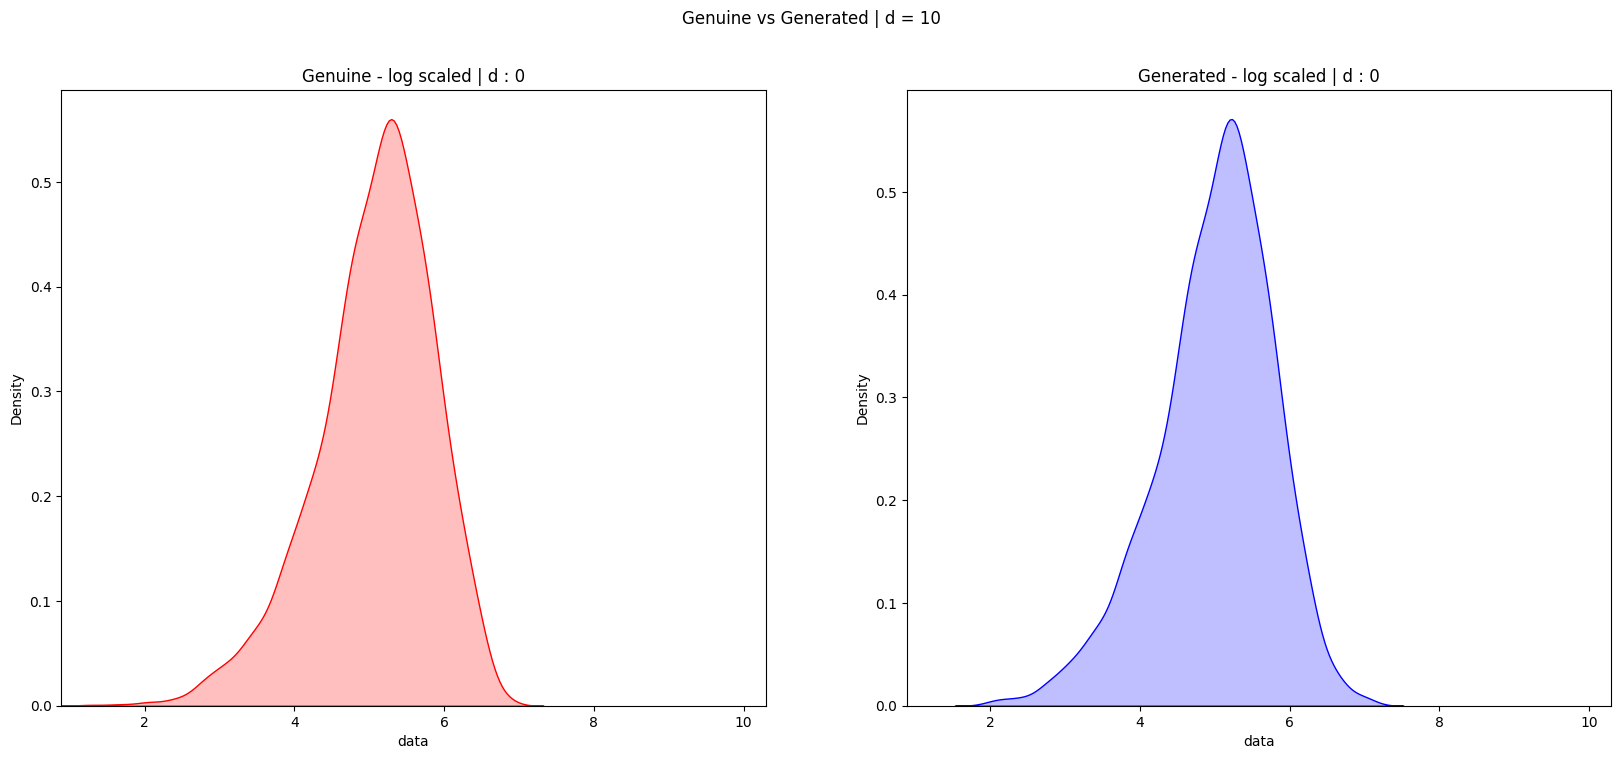

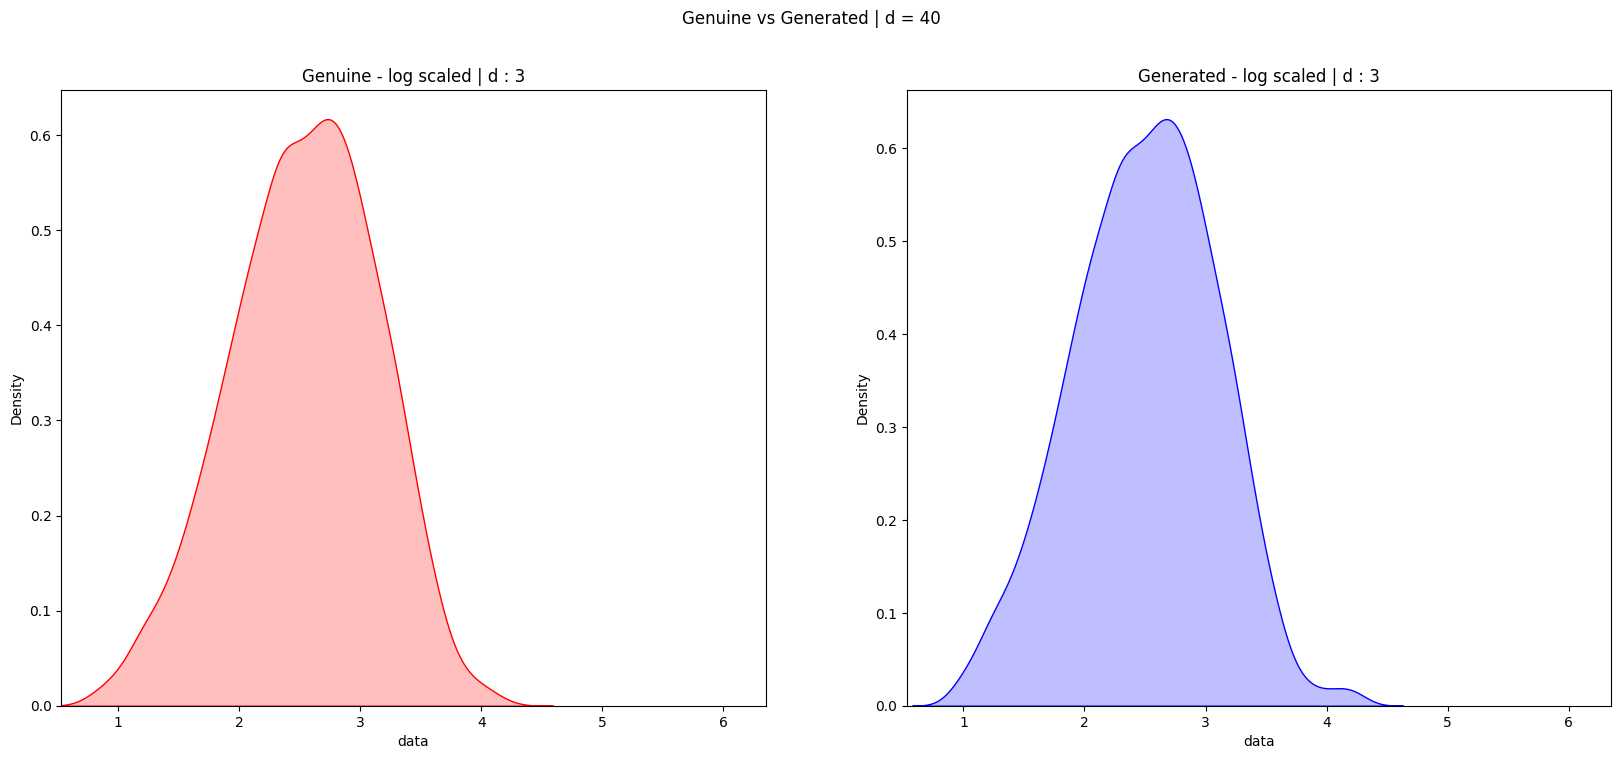

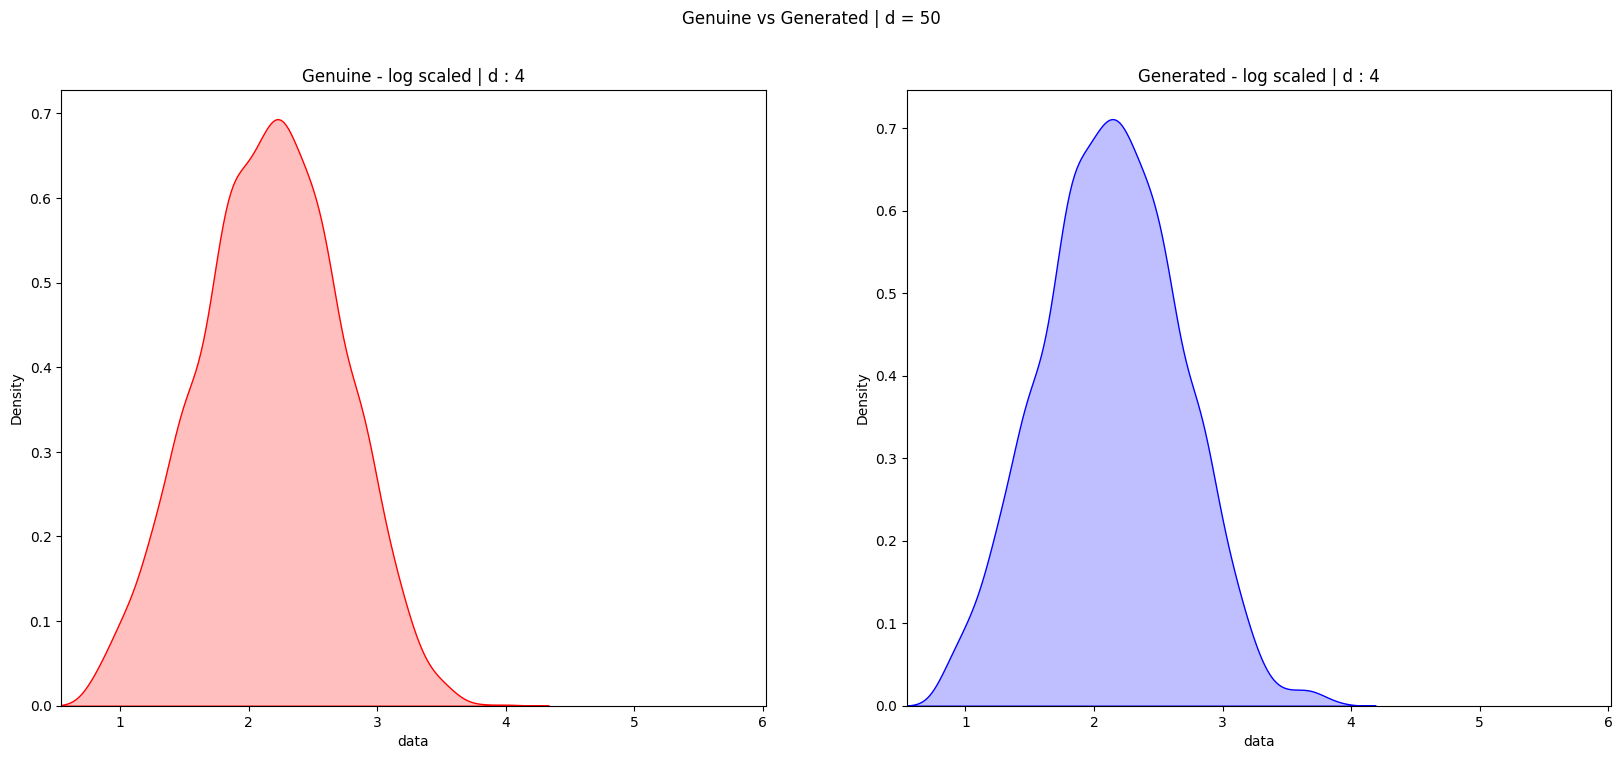

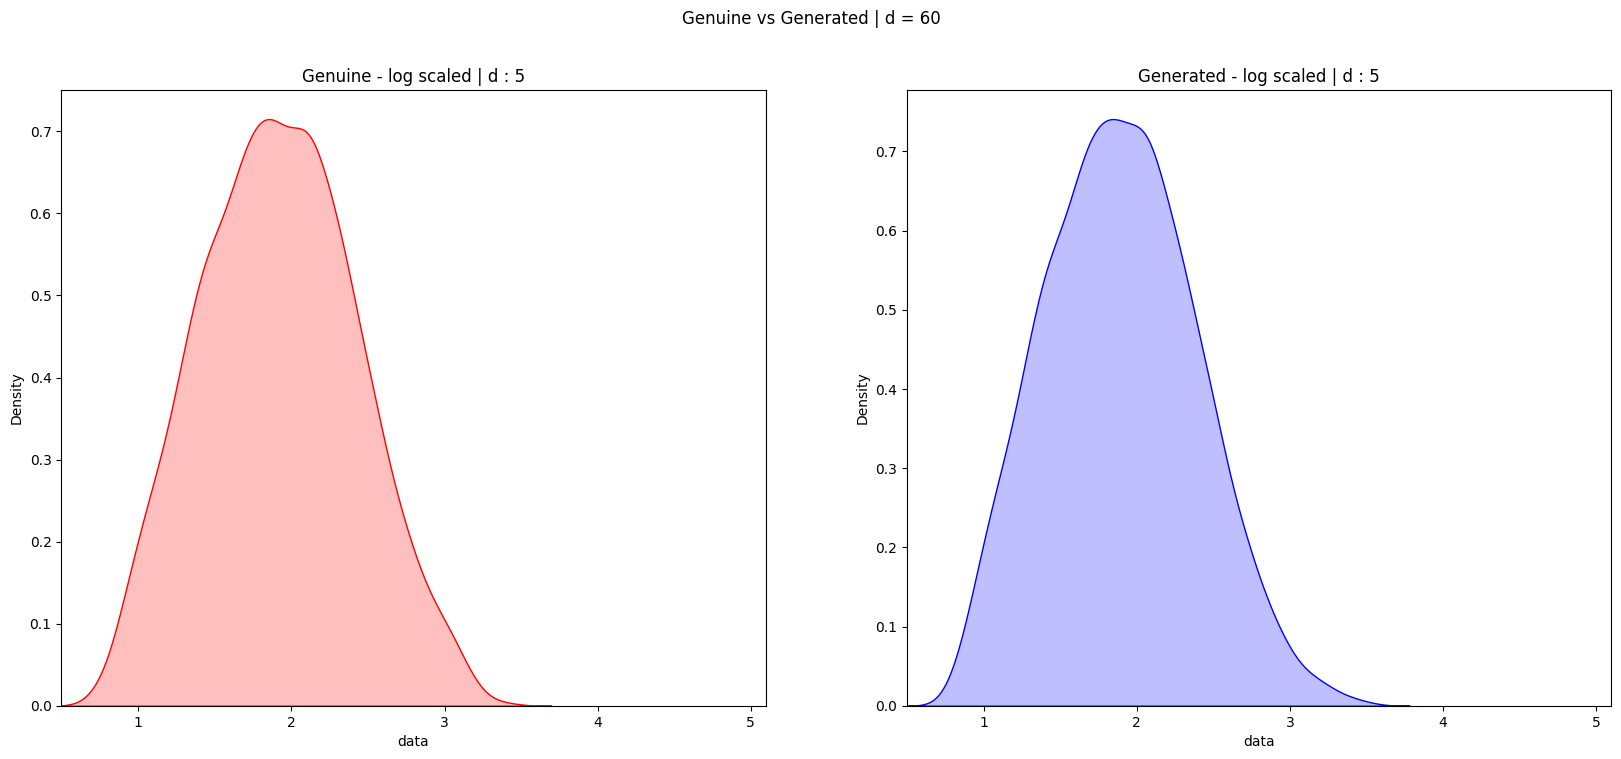

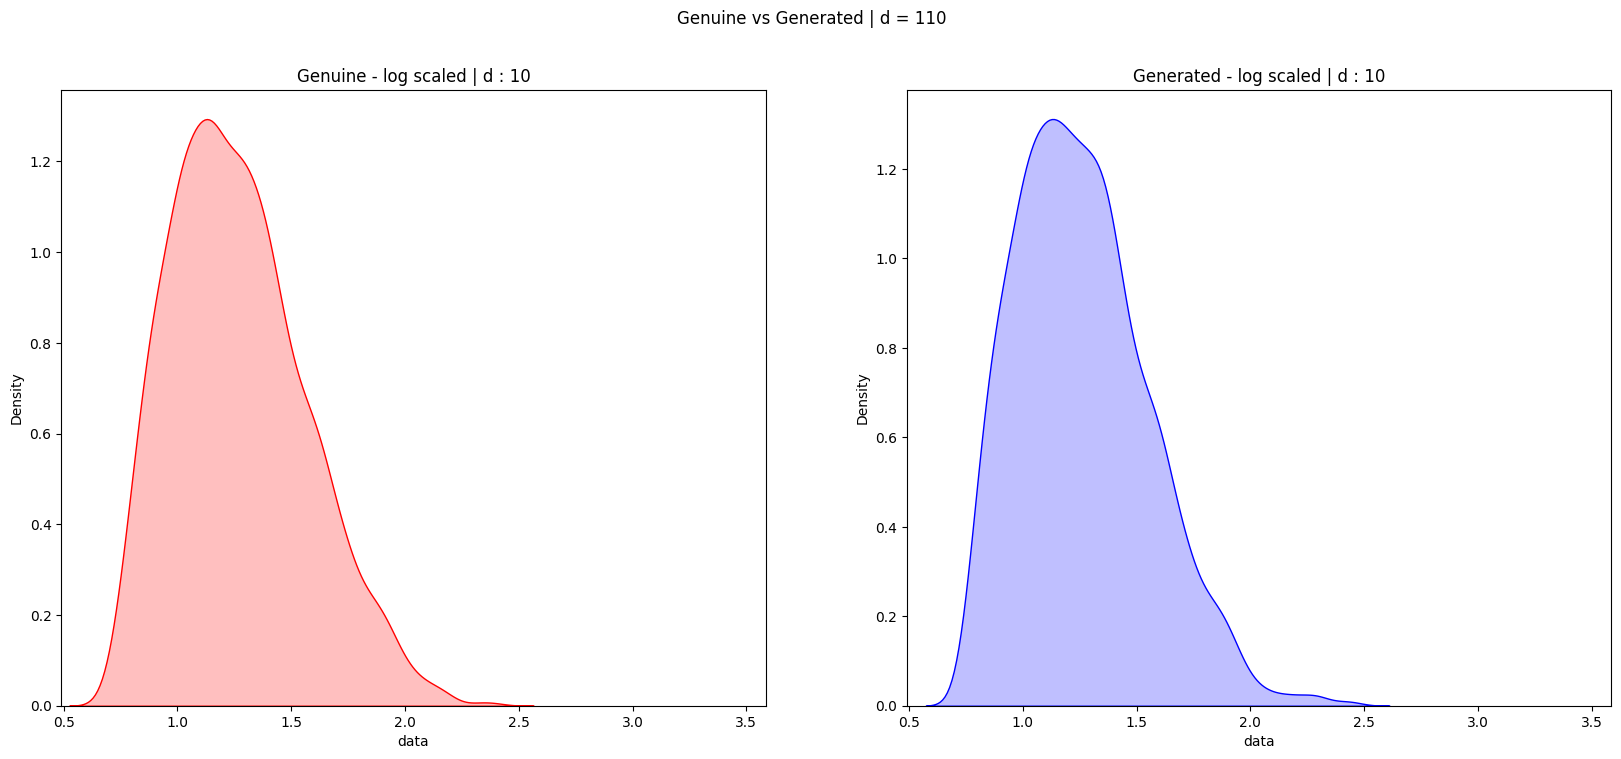

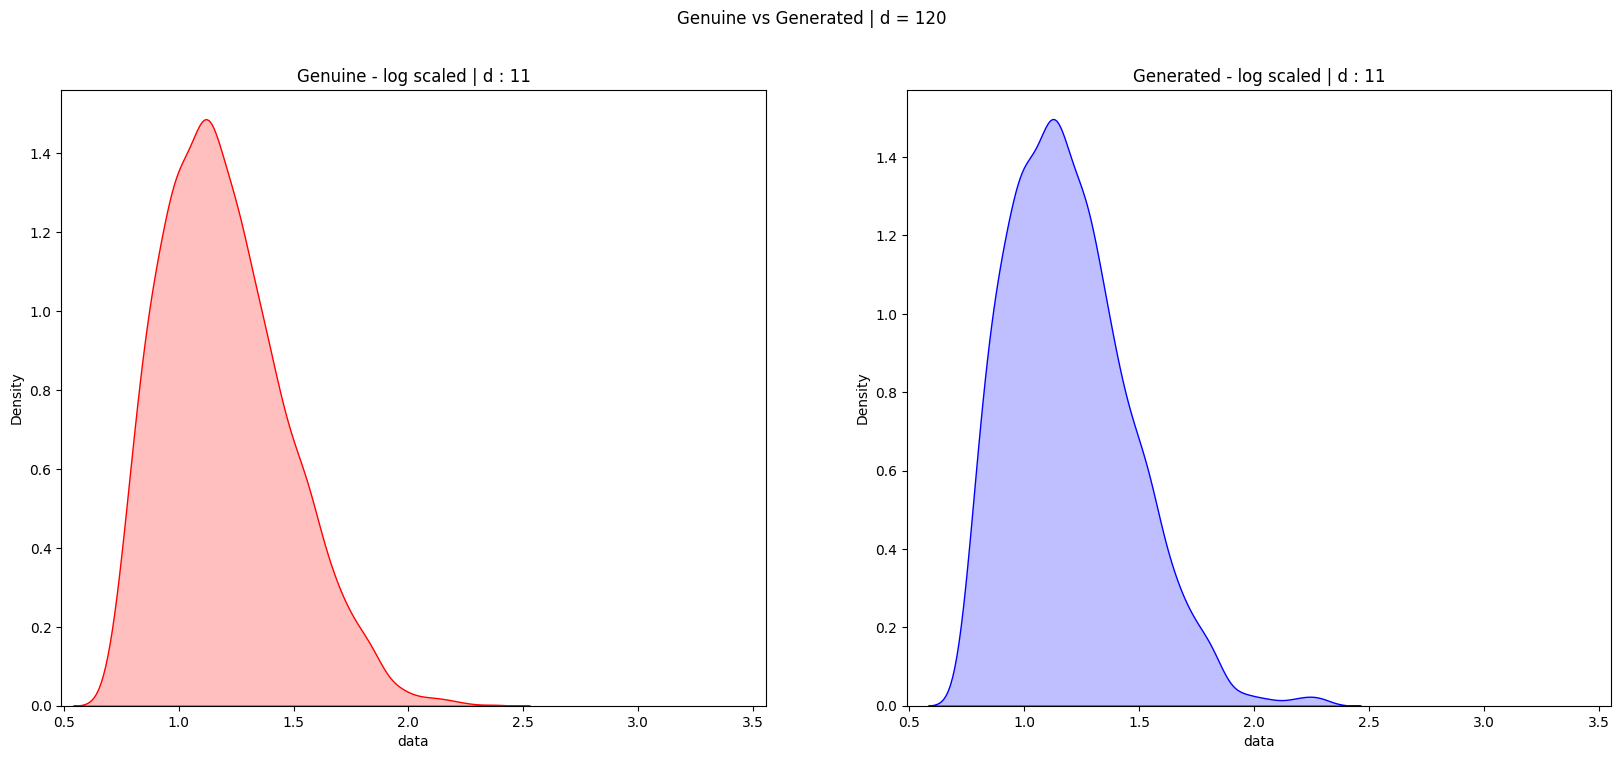

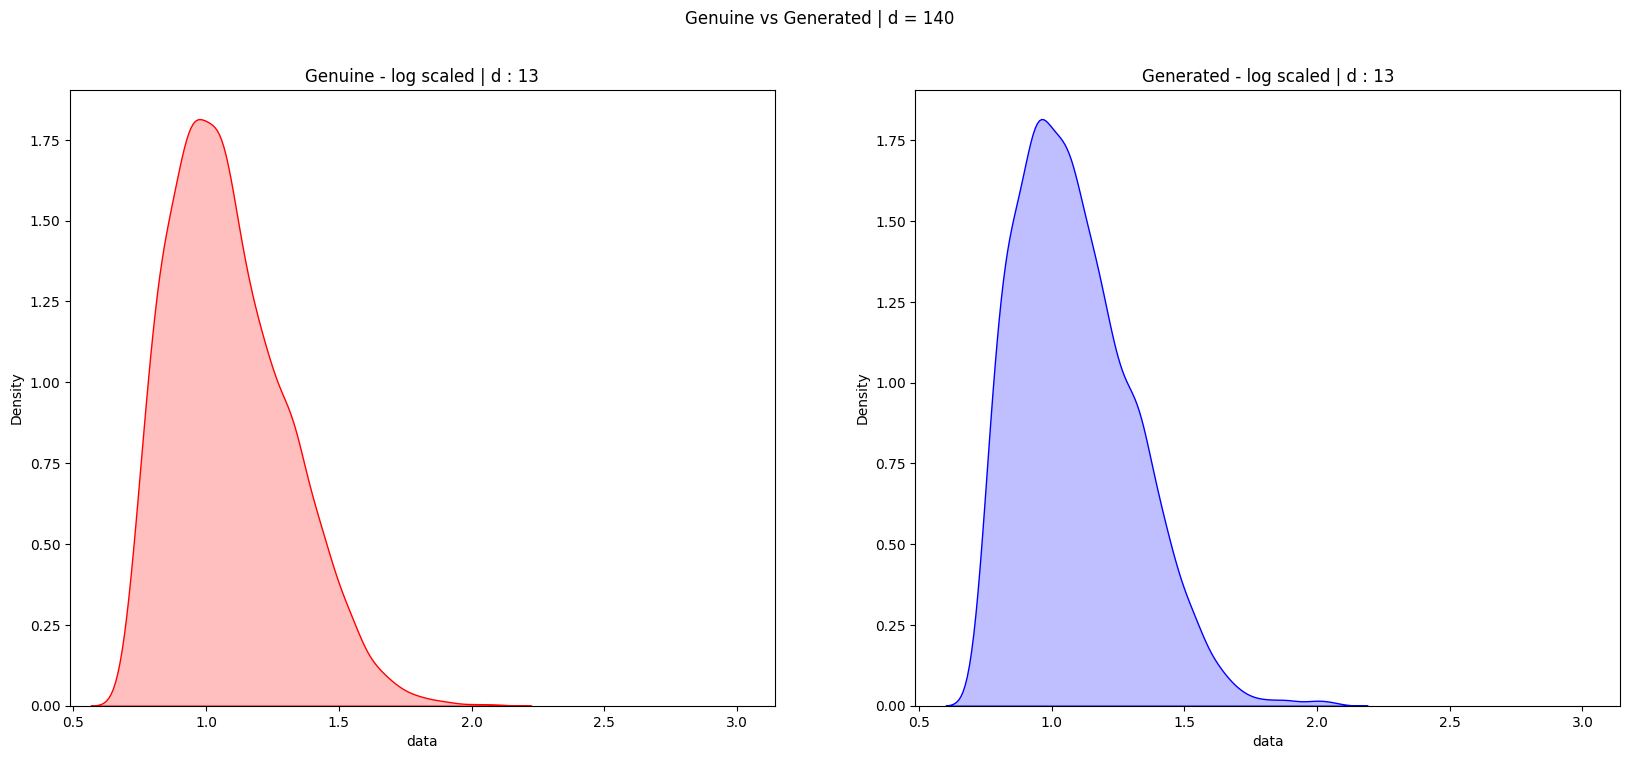

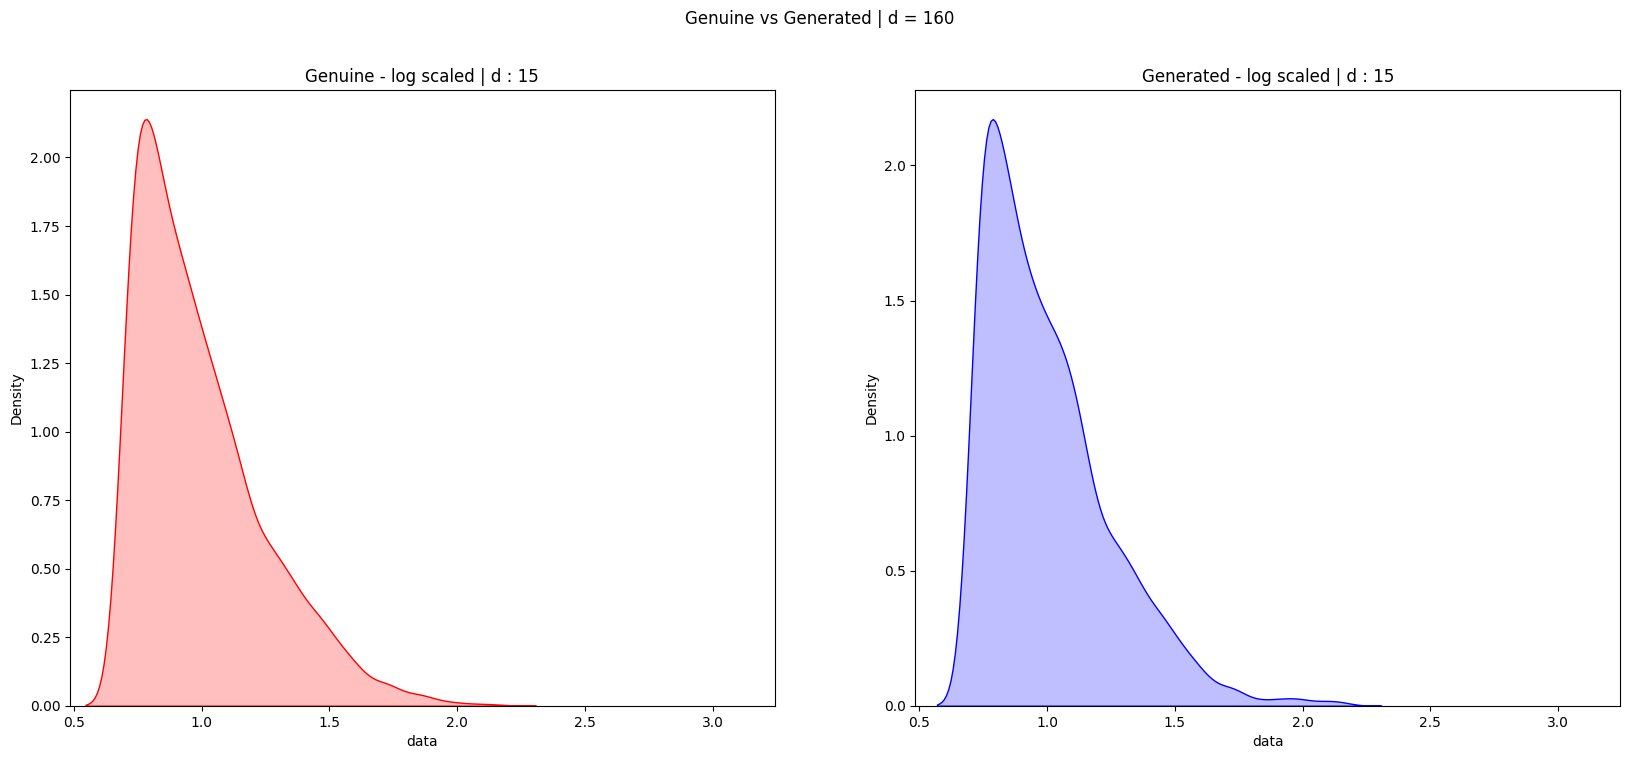

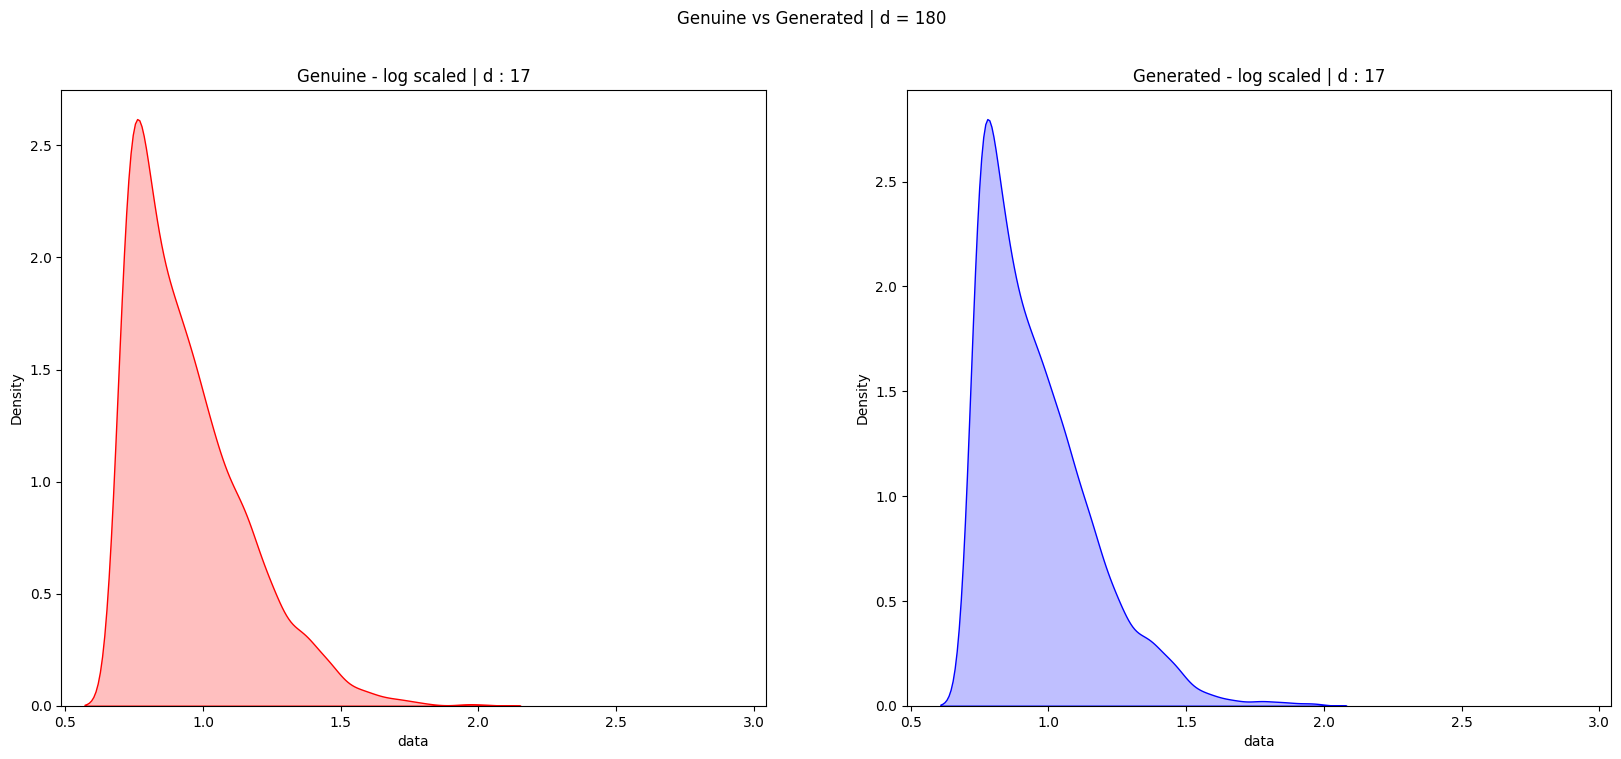

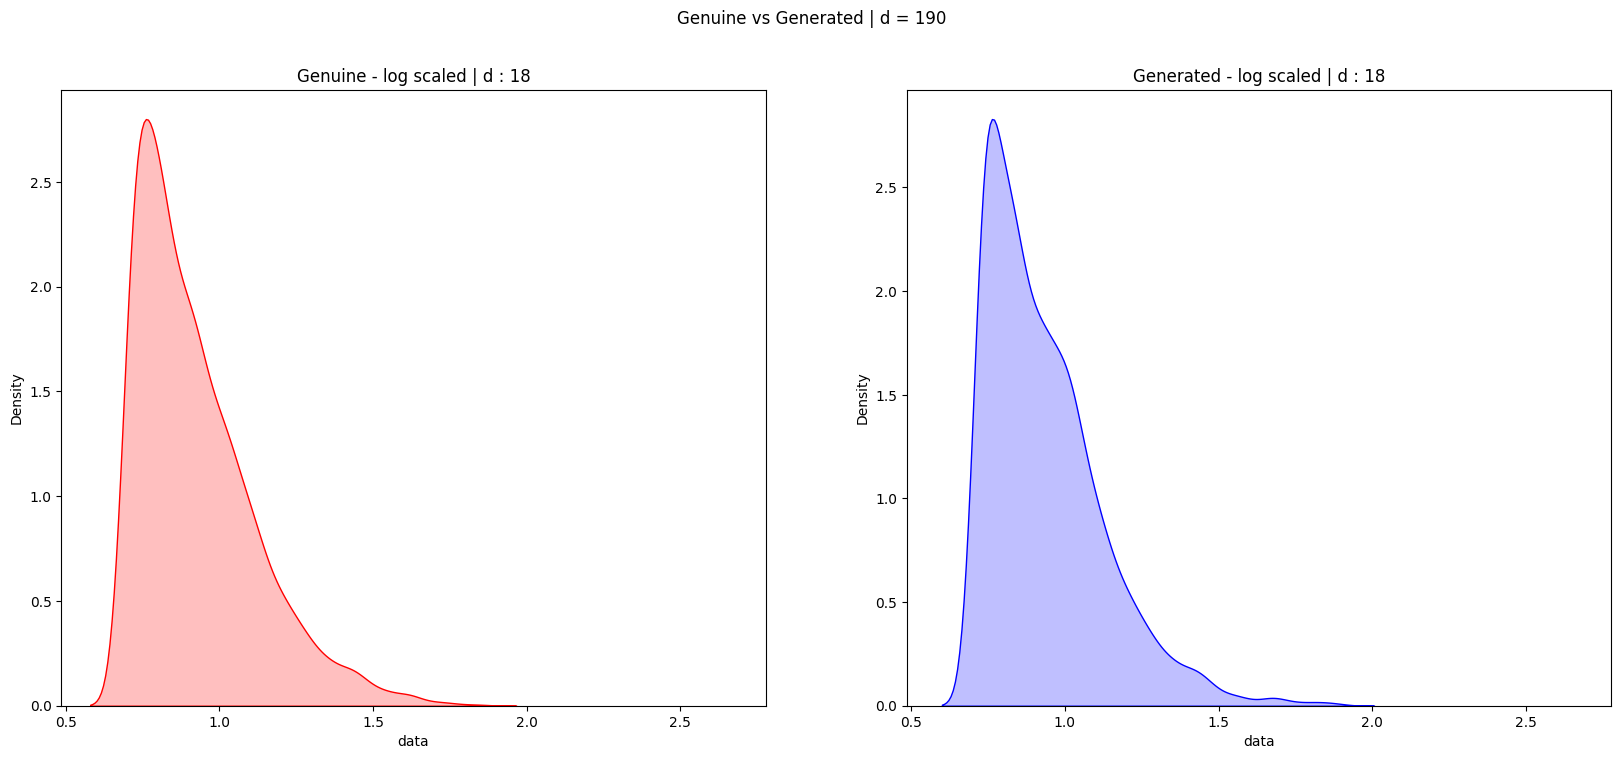

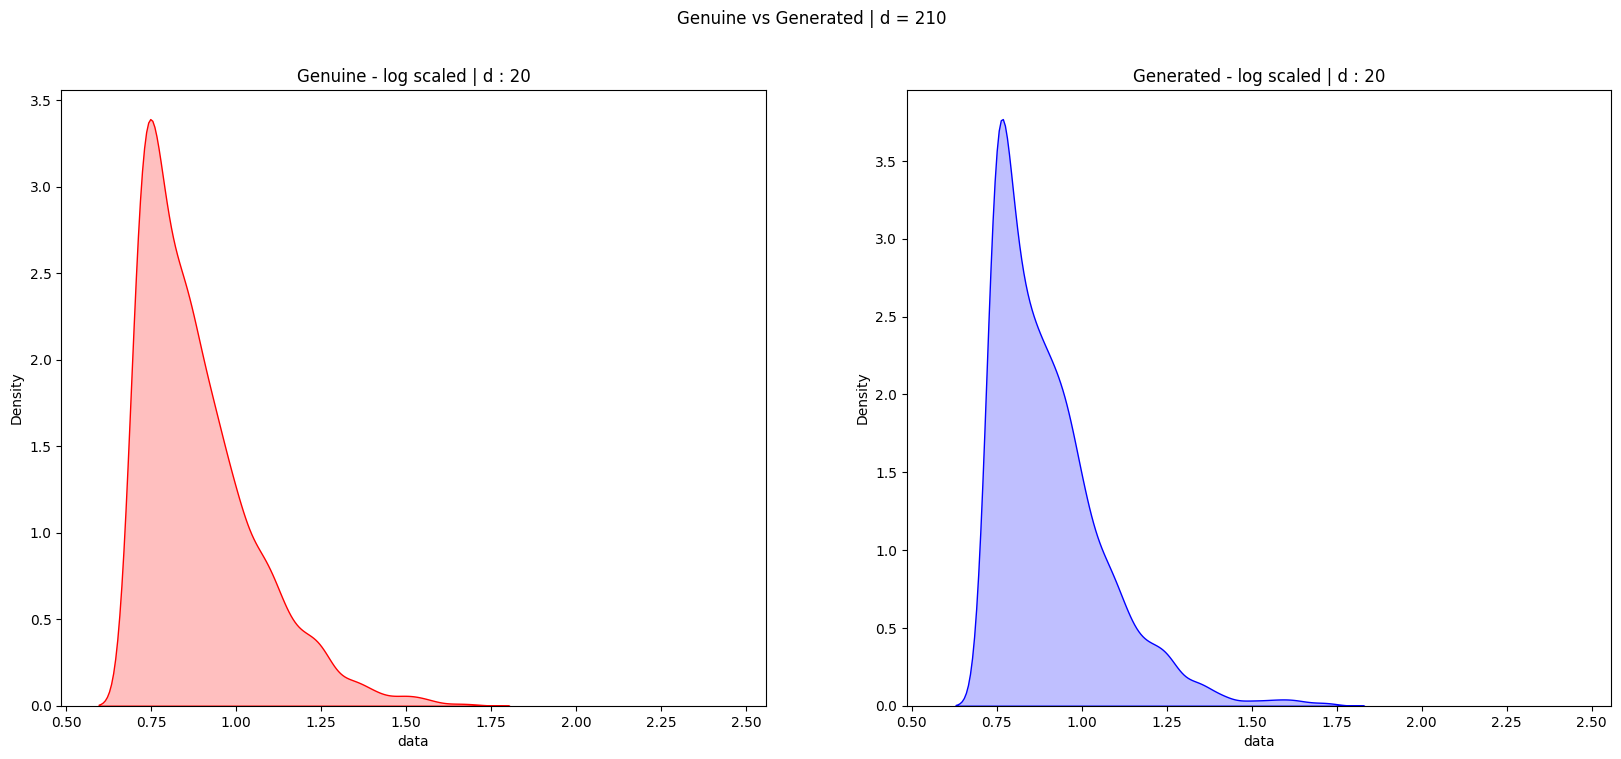

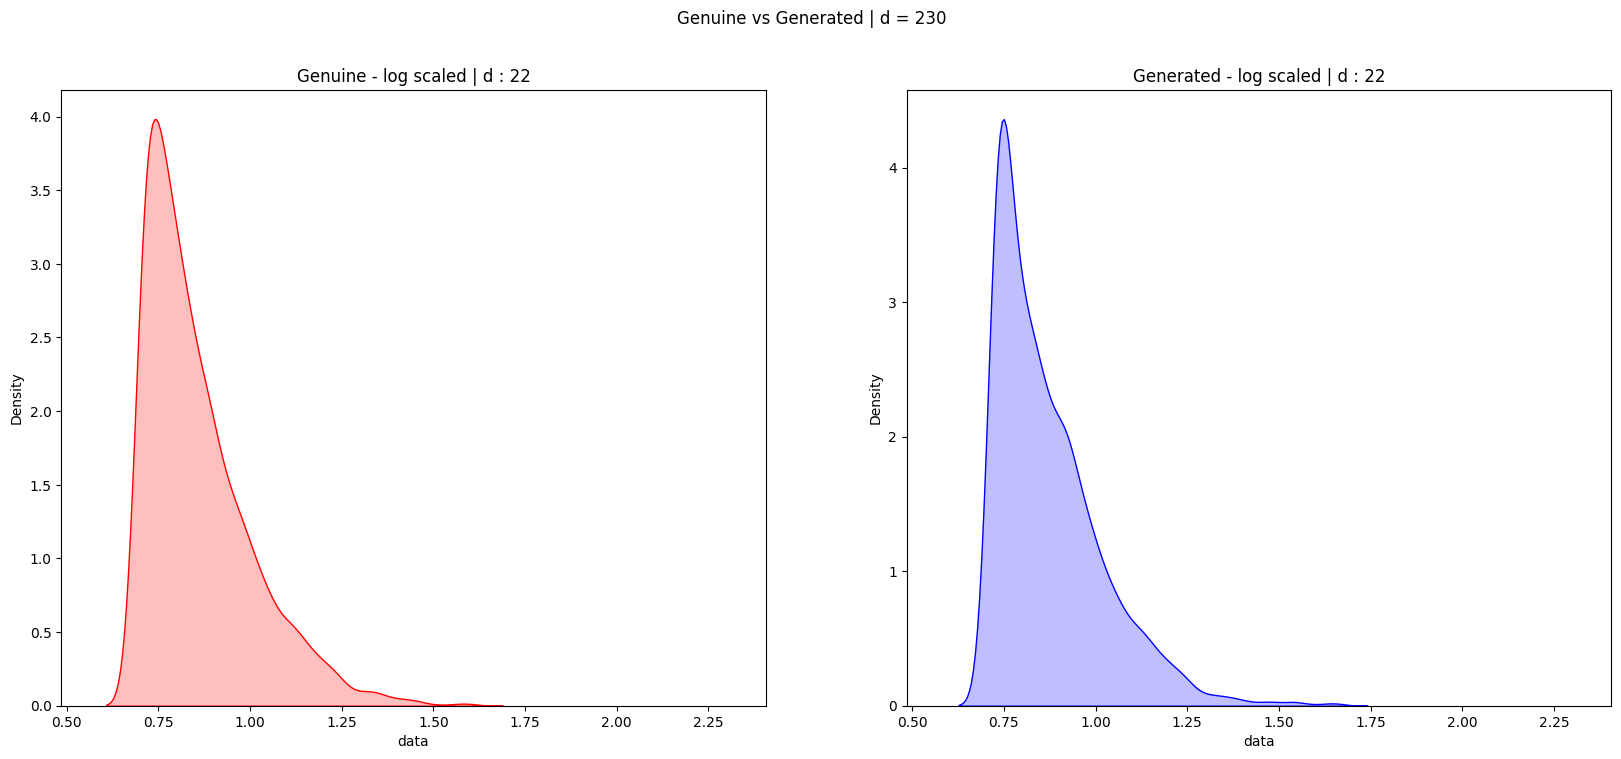

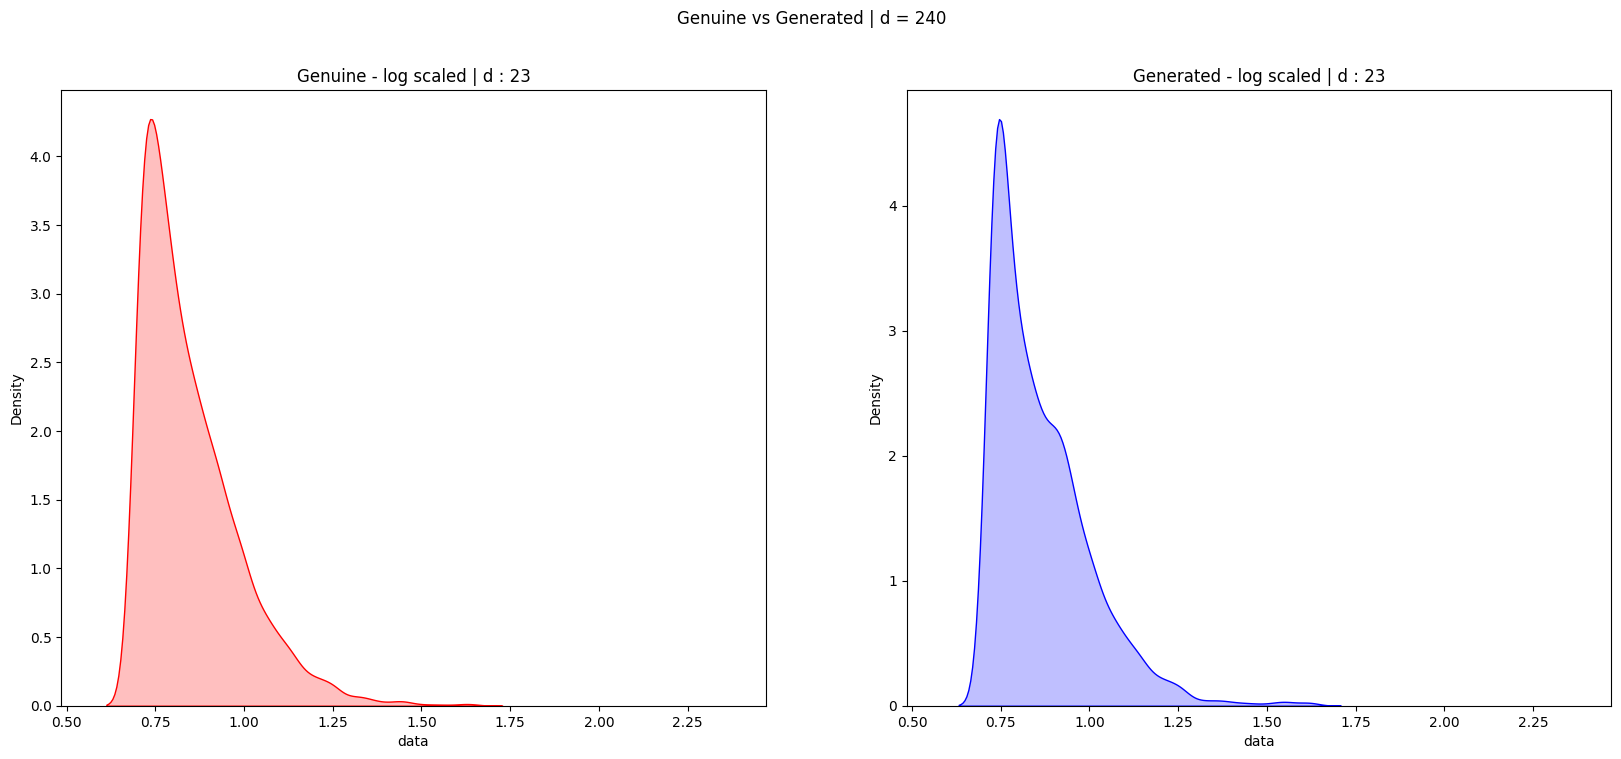

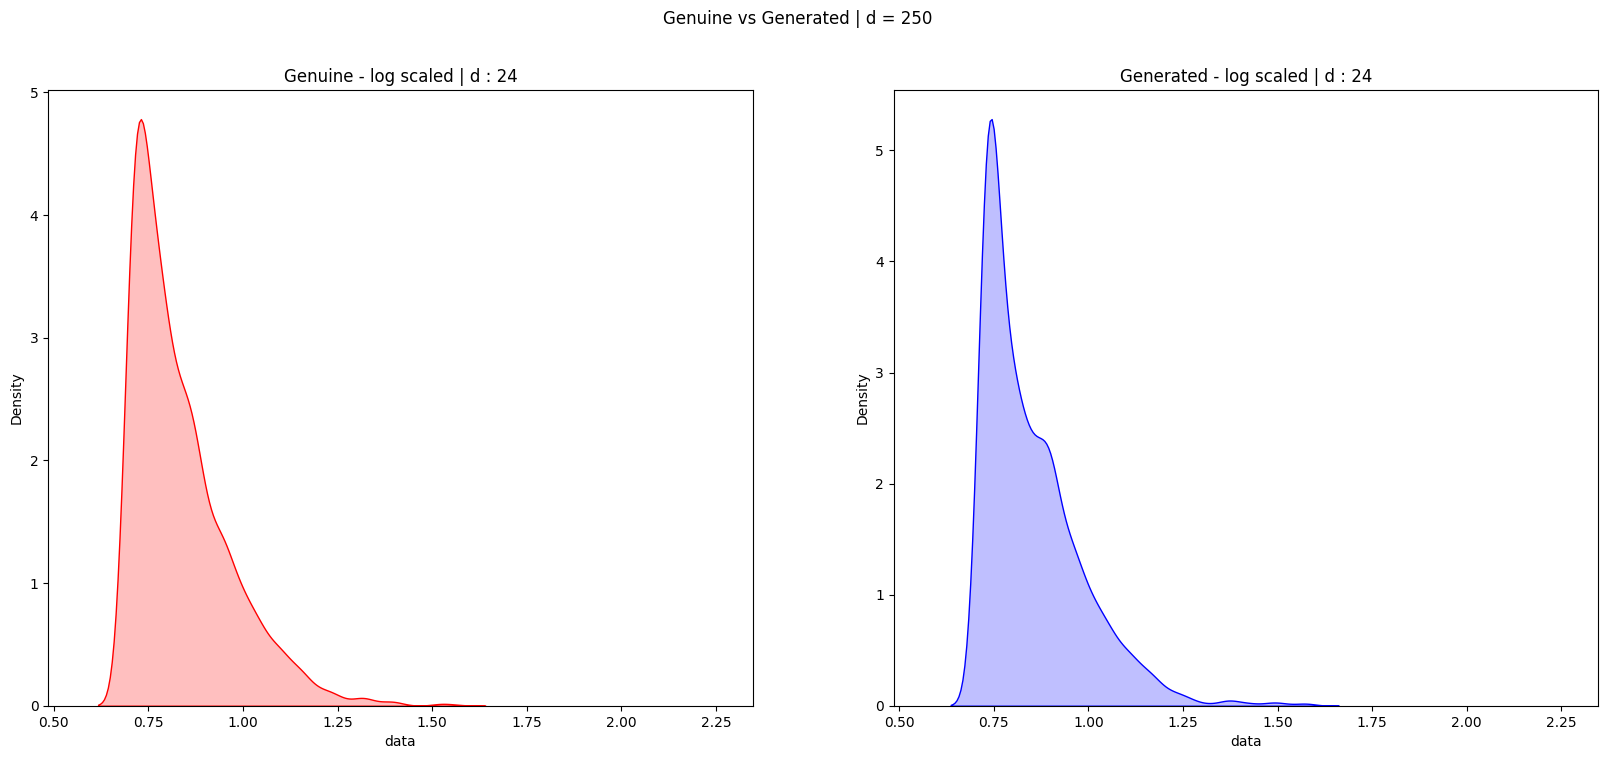

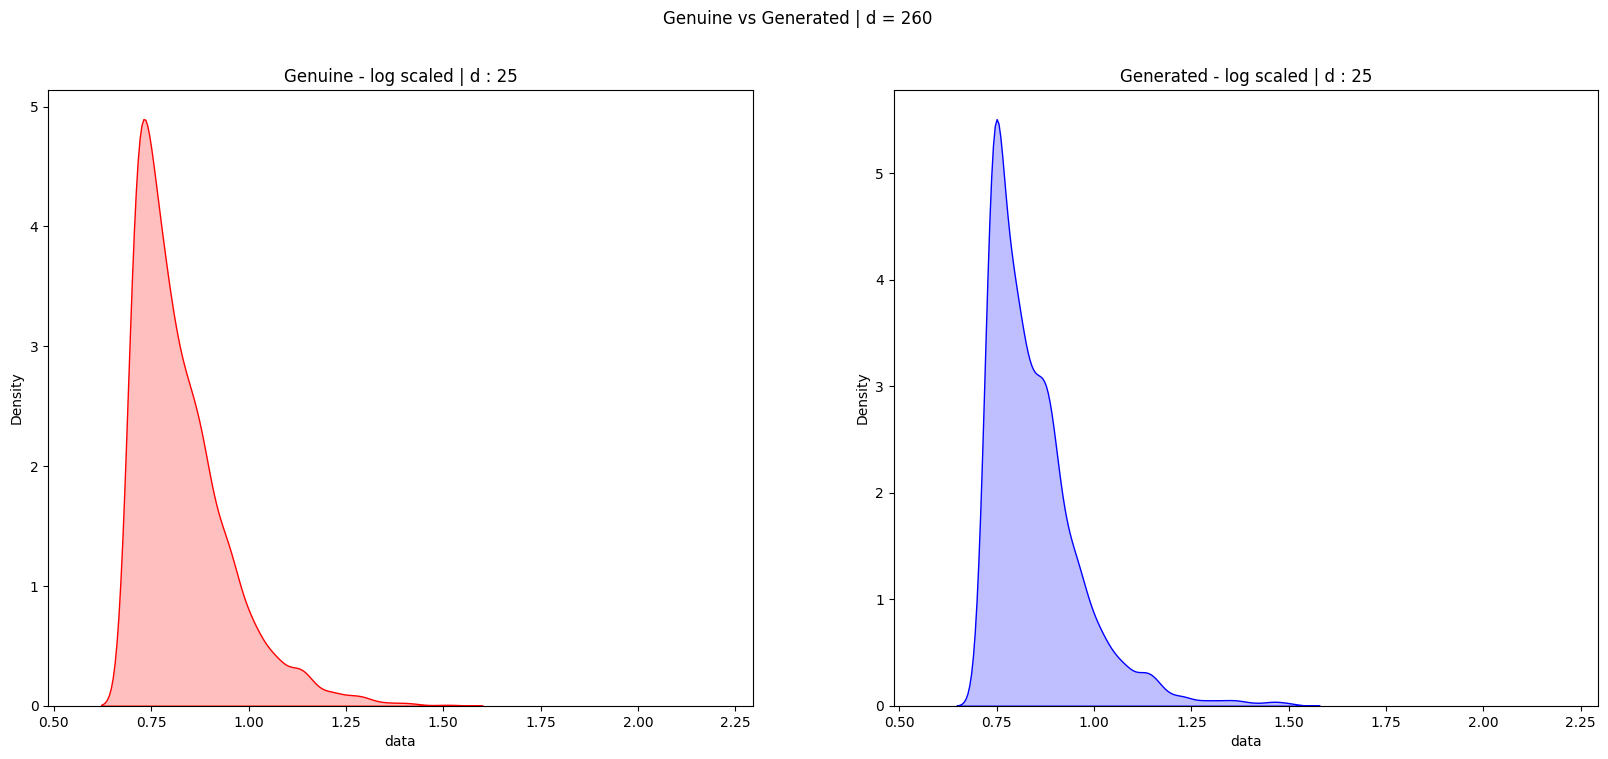

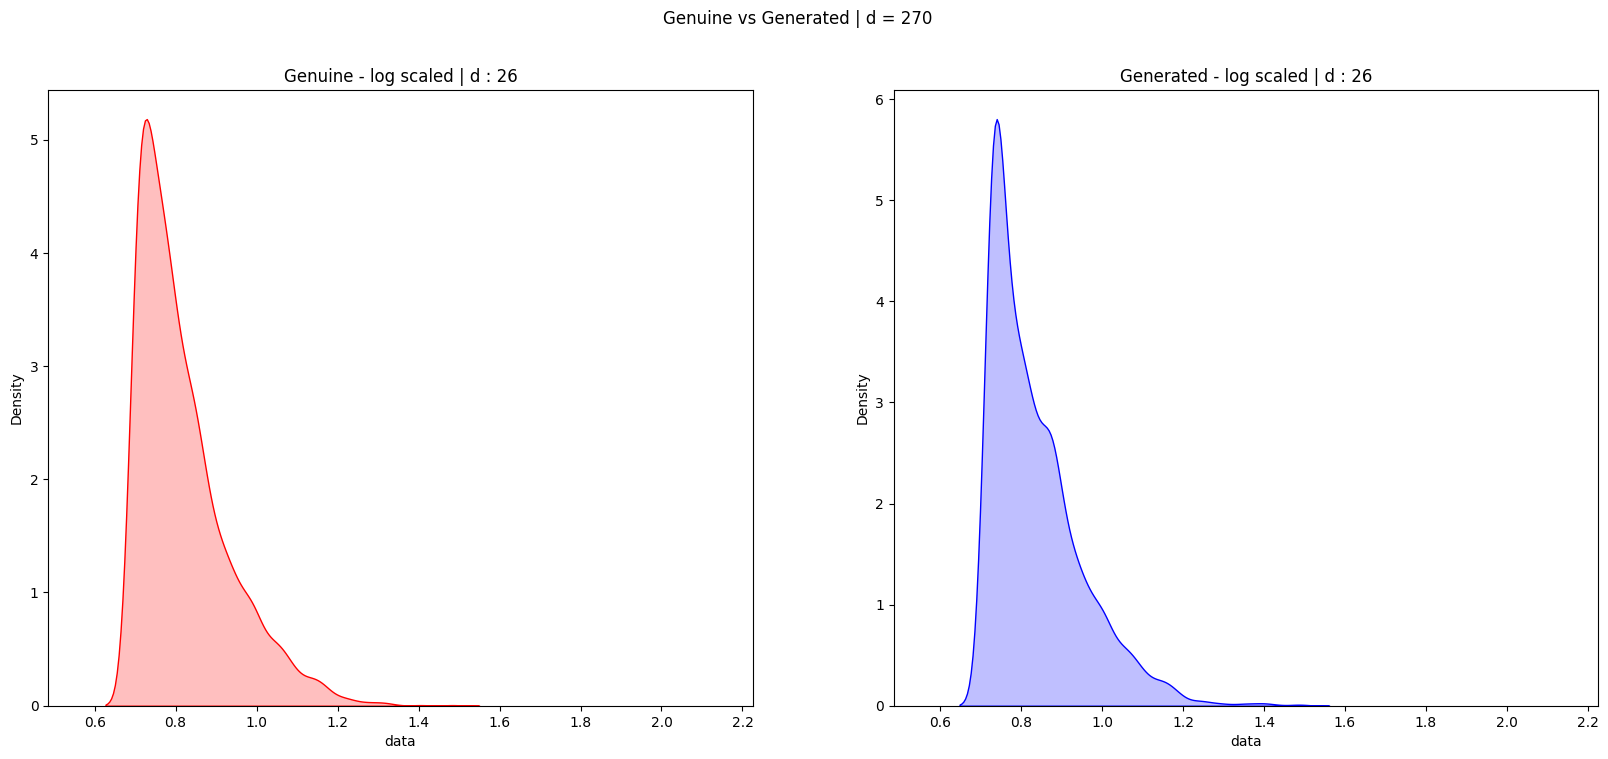

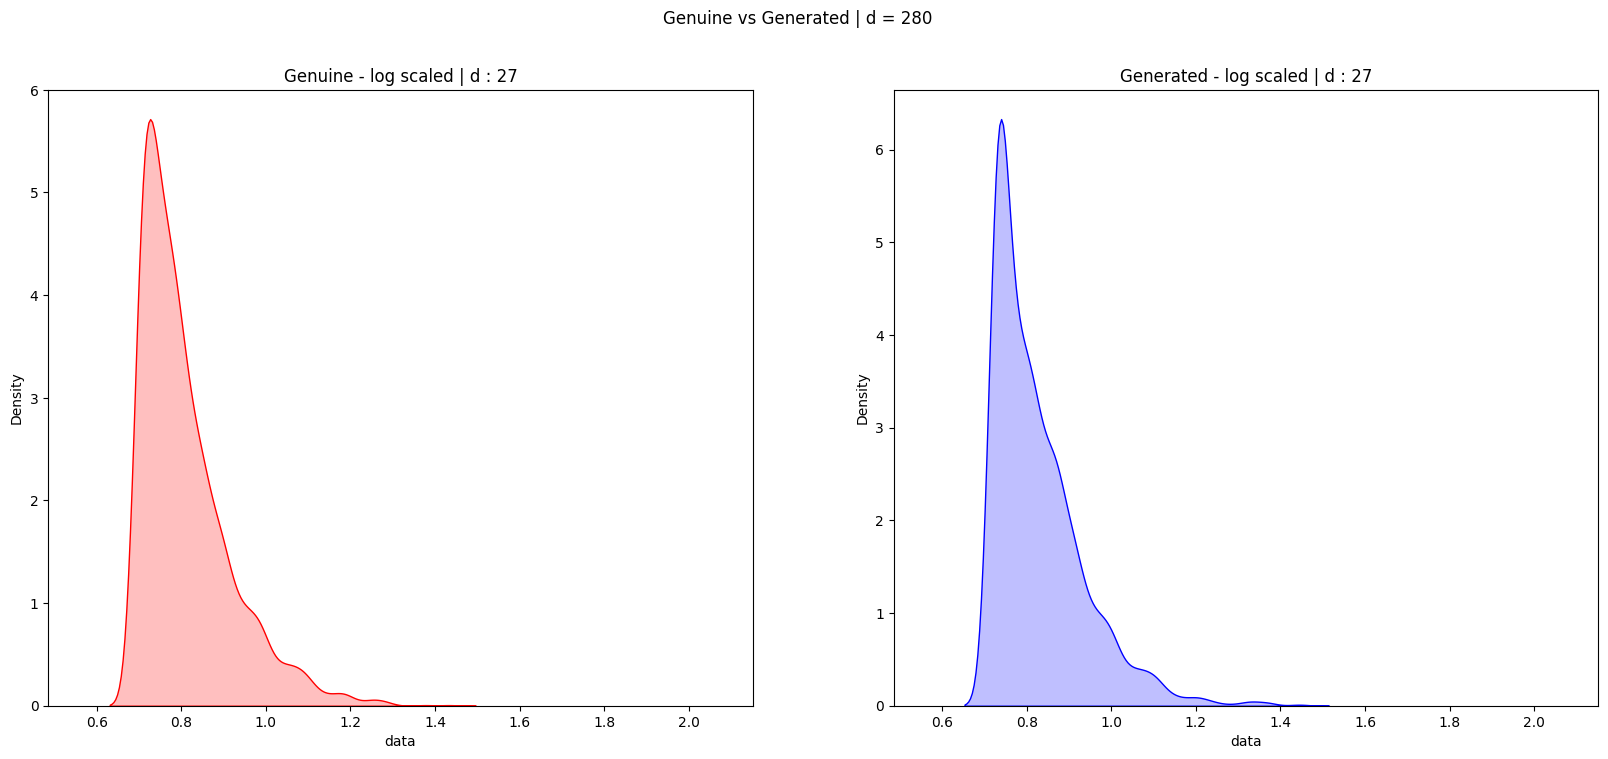

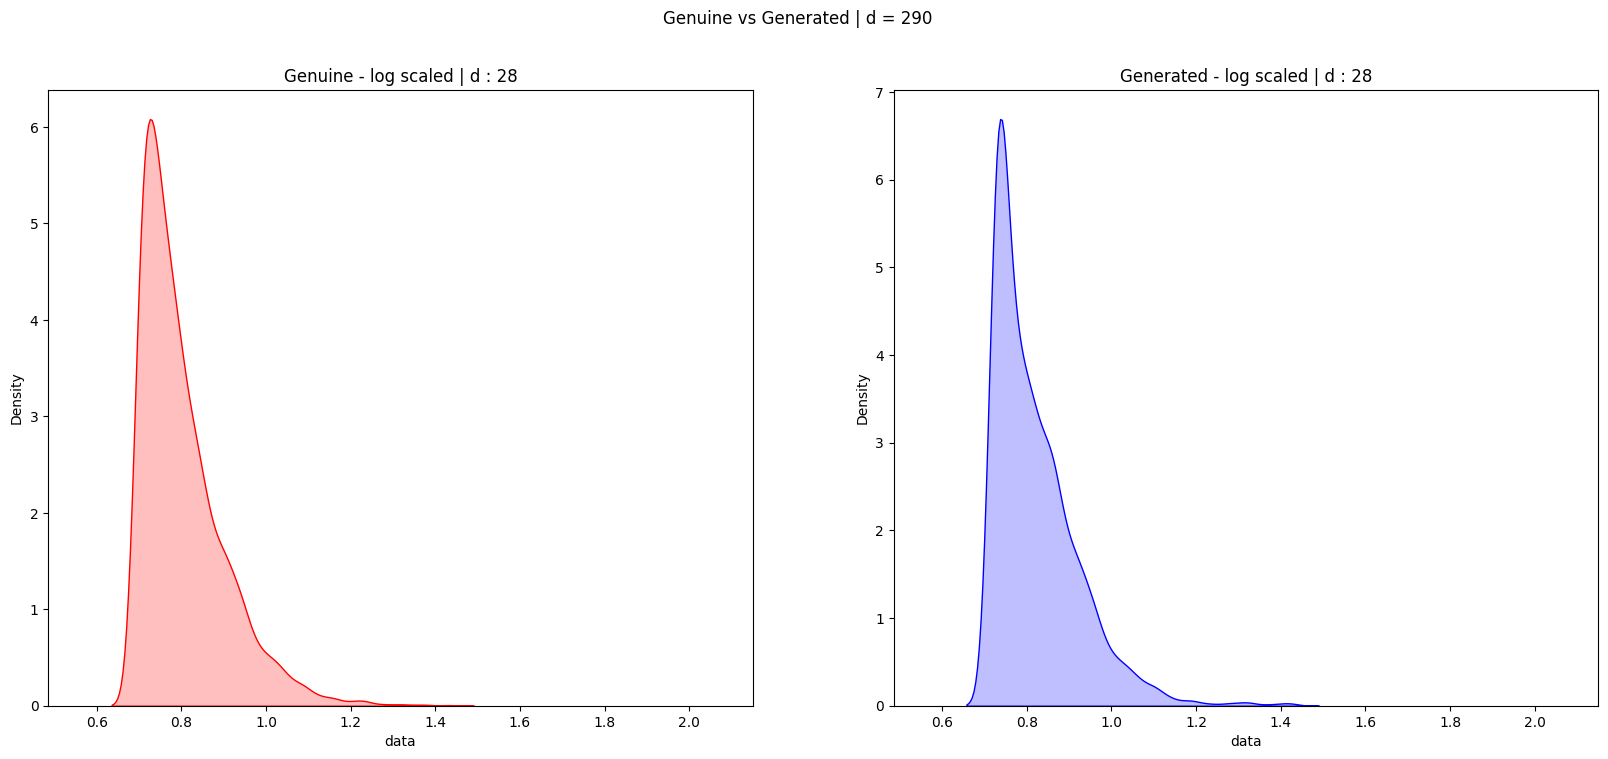

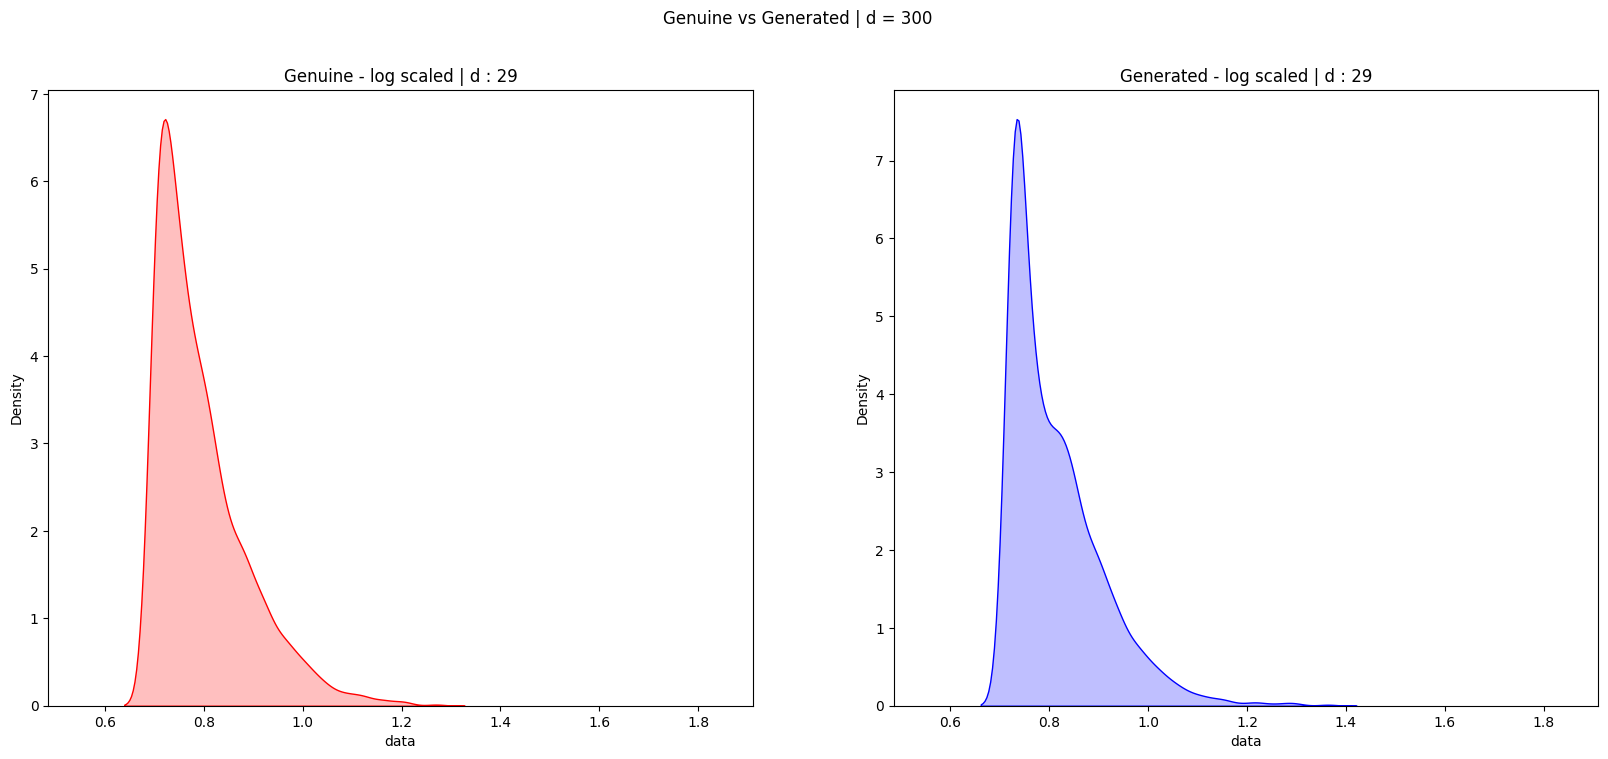

In [33]:
_d_array = np.arange(10, 301, 10, dtype=np.int32)
for i in range(len(df_genuine_log_scaled_eval['d'].unique())):
    # Melt the data to long-form
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    sns.kdeplot(data=df_genuine_log_scaled_eval[df_genuine_log_scaled_eval['d'] == i], x='data', 
                fill=True, ax=ax1, color='red')
    ax1.set_title(f"Genuine - log scaled | d : {i}")
    x_range_plot_logged = df_genuine_log_scaled_eval[df_genuine_log_scaled_eval['d'] == i]['data']
    sns.kdeplot(data=df_generated_log_scaled_eval[df_generated_log_scaled_eval['d'] == i], x='data', 
                fill=True, ax=ax2, color='blue')
    ax2.set_title(f"Generated - log scaled | d : {i}")



    ax1.set_xlim([x_range_plot_logged.min()*0.7, x_range_plot_logged.max()*1.5])
    ax2.set_xlim([x_range_plot_logged.min()*0.7, x_range_plot_logged.max()*1.5])
    
    
    fig.suptitle(f"Genuine vs Generated | d = {_d_array[i]}")
    plt.show()

In [34]:
df_afterward_log_scaled = df_generated_log_scaled_eval.copy()
df_afterward_log_scaled.rename(columns={'data':'genuine'}, inplace=True)
df_afterward_log_scaled['generated'] = df_generated_log_scaled_eval['data']
df_afterward_log_scaled

genuine     d         r  generated
0      1.206375  13.0  0.724528   1.206375
1      0.790464  18.0  0.269023   0.790464
2      0.857254  20.0  0.491820   0.857254
3      0.945035  16.0  0.530306   0.945035
4      1.230786   6.0  0.151977   1.230786
...         ...   ...       ...        ...
99995  1.047669   8.0  0.144631   1.047669
99996  0.922372  25.0  0.805632   0.922372
99997  0.795282  26.0  0.469878   0.795282
99998  1.604696  11.0  0.928795   1.604696
99999  1.308837   8.0  0.399134   1.308837

[100000 rows x 4 columns]

### Genuine vs Generated Comparison - with __scaled back__

In [35]:
df_afterward_back_scaled = df_genuine_log_scaled_eval.copy()
df_afterward_back_scaled['data'] = inverse_log_transform(df_genuine_log_scaled_eval['data'])
df_afterward_back_scaled.rename(columns={'data':'genuine'}, inplace=True)
df_afterward_back_scaled['generated'] = inverse_log_transform(df_generated_log_scaled_eval['data'])
df_afterward_back_scaled

genuine     d  generated
0      1.341073  13.0   1.341348
1      0.178354  18.0   0.204418
2      0.315373  20.0   0.356681
3      0.537234  16.0   0.572904
4      1.444426   6.0   1.423920
...         ...   ...        ...
99995  0.846722   8.0   0.850998
99996  0.497846  25.0   0.515250
99997  0.178868  26.0   0.215065
99998  3.076329  11.0   2.976346
99999  1.742517   8.0   1.701867

[100000 rows x 3 columns]

In [36]:
df_afterward_back_scaled_vertical = pd.melt(df_afterward_back_scaled, id_vars=['d'], value_vars=['genuine', 'generated'],
                      var_name='aux', value_name='data').sort_values(by='aux', ascending=False)
df_afterward_back_scaled_vertical

d        aux        data
0       13.0    genuine    1.341073
66651   11.0    genuine    0.237203
66673   10.0    genuine    0.319689
66672   28.0    genuine    0.026372
66671    8.0    genuine    1.478342
...      ...        ...         ...
133331  29.0  generated    0.077444
133330   0.0  generated  560.457397
133329  25.0  generated    0.091016
133328  14.0  generated    0.434884
199999   8.0  generated    1.701867

[200000 rows x 3 columns]

### Overlapped Area

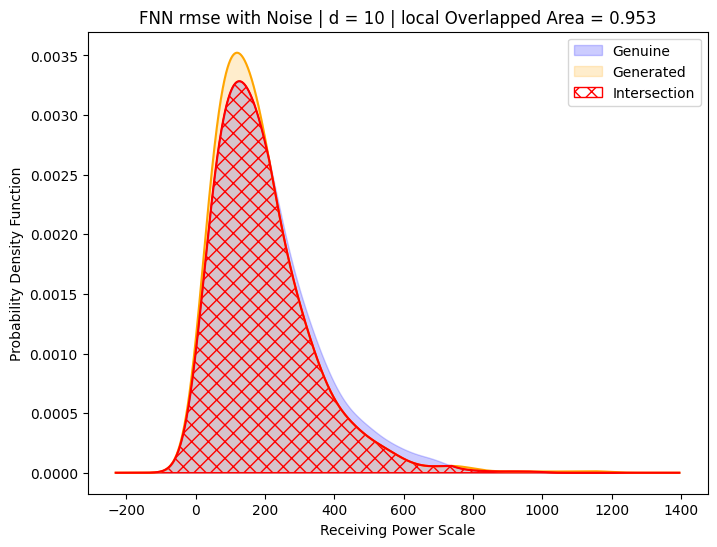

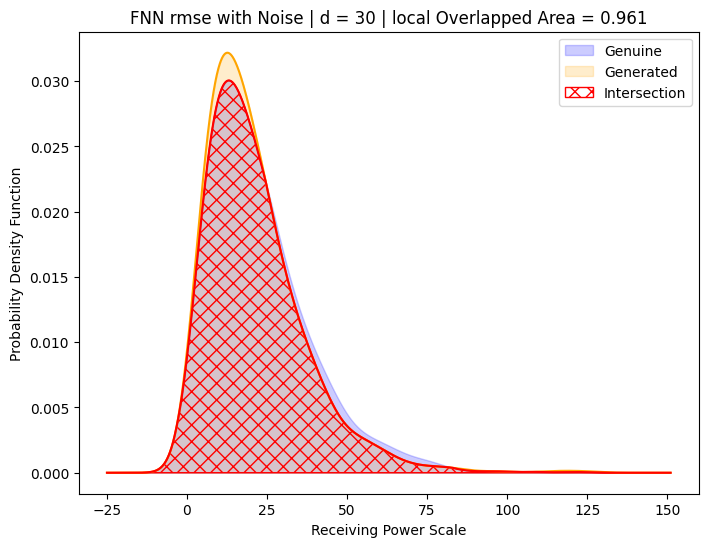

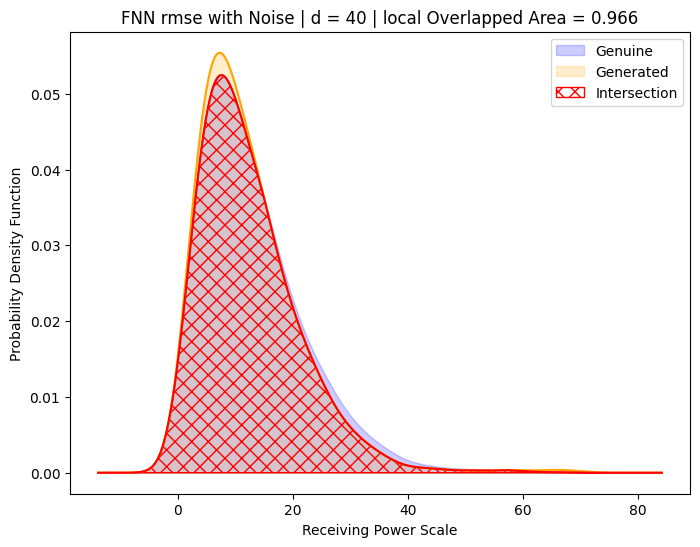

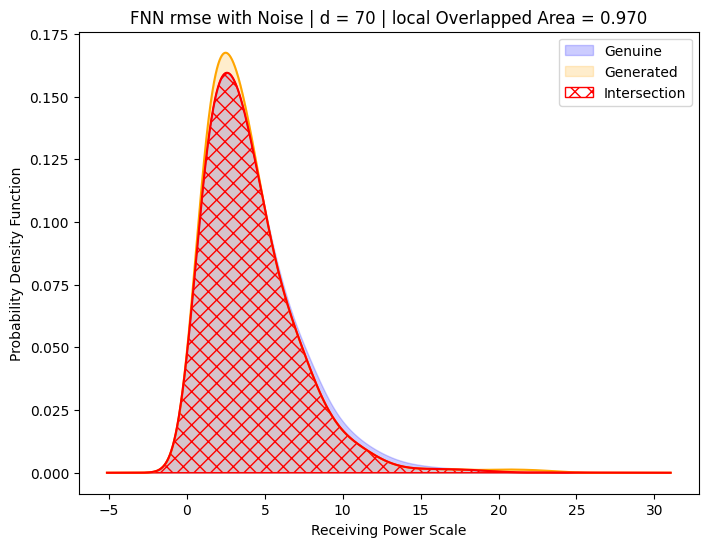

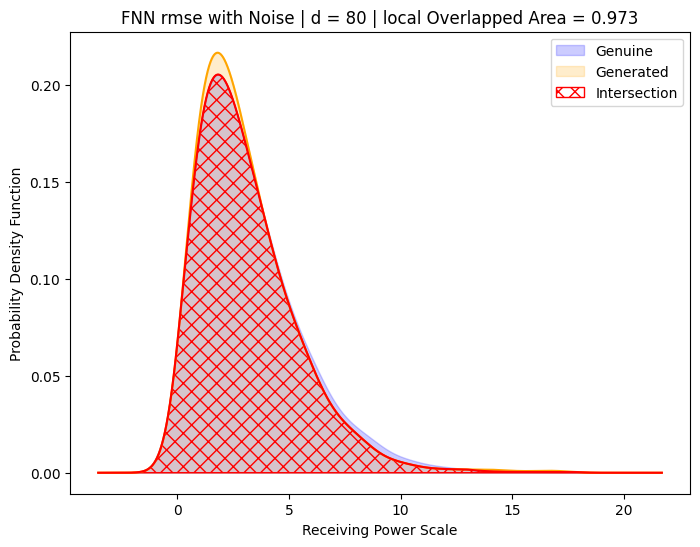

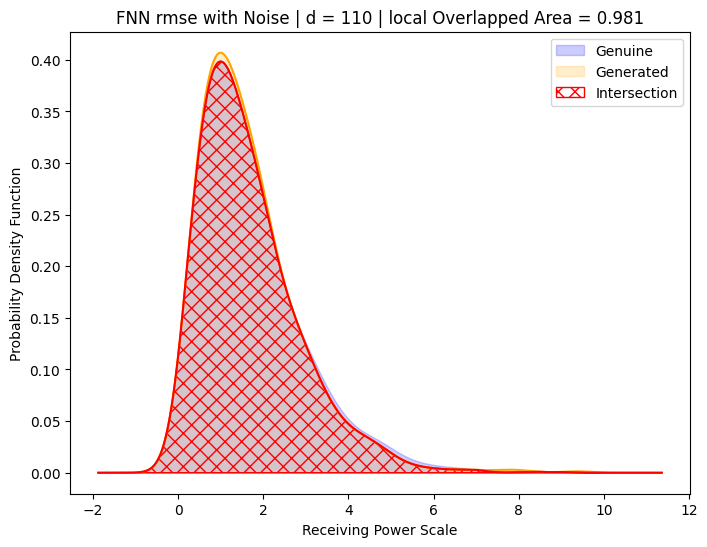

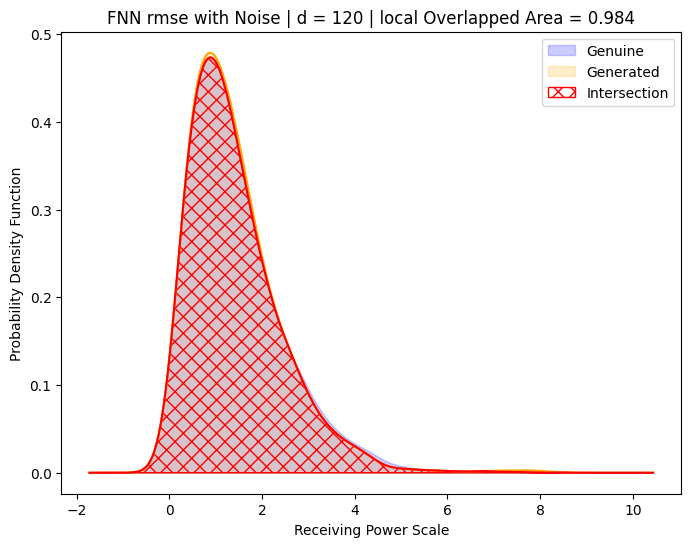

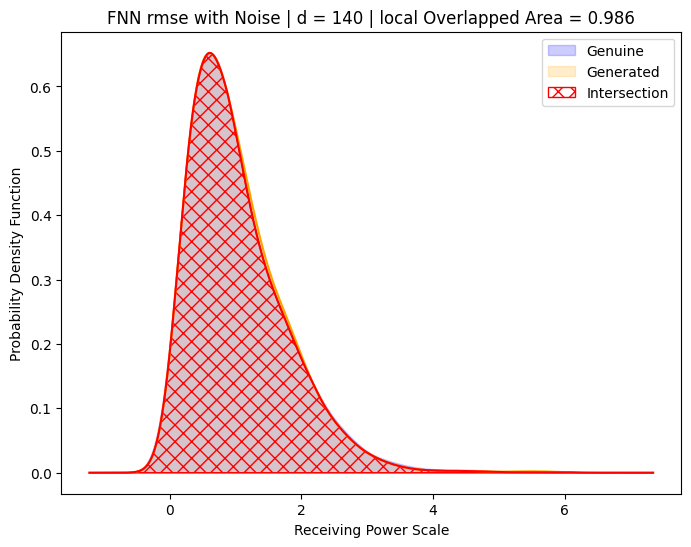

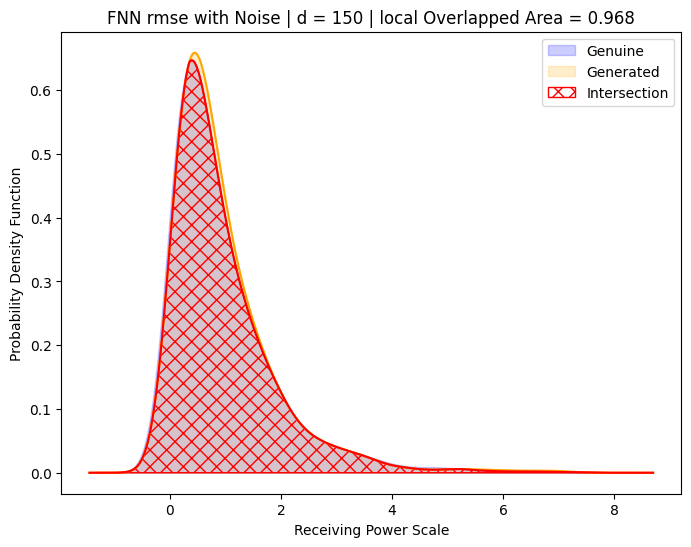

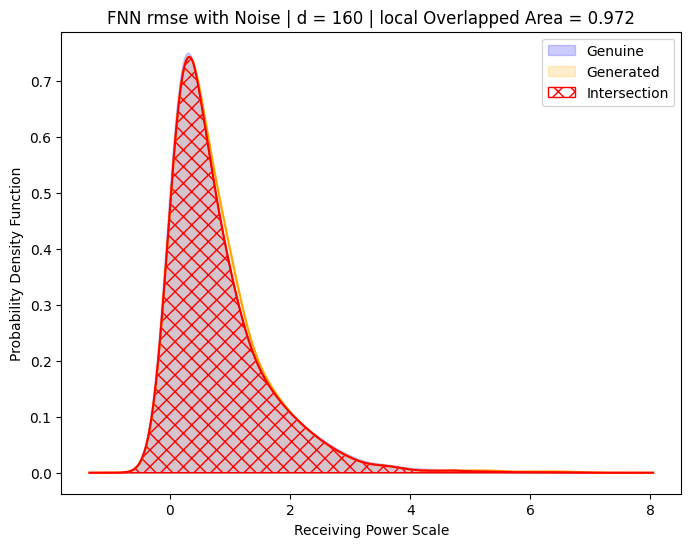

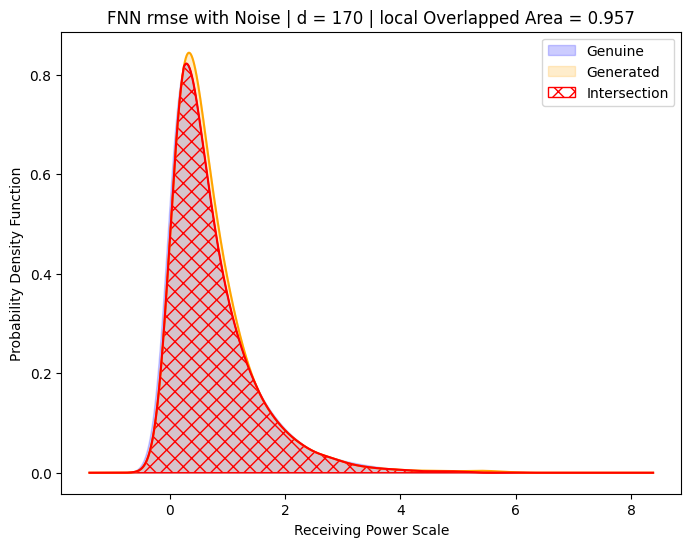

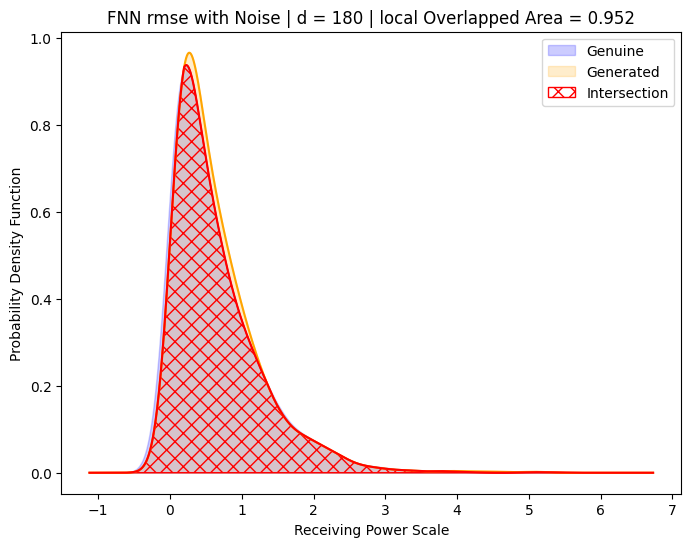

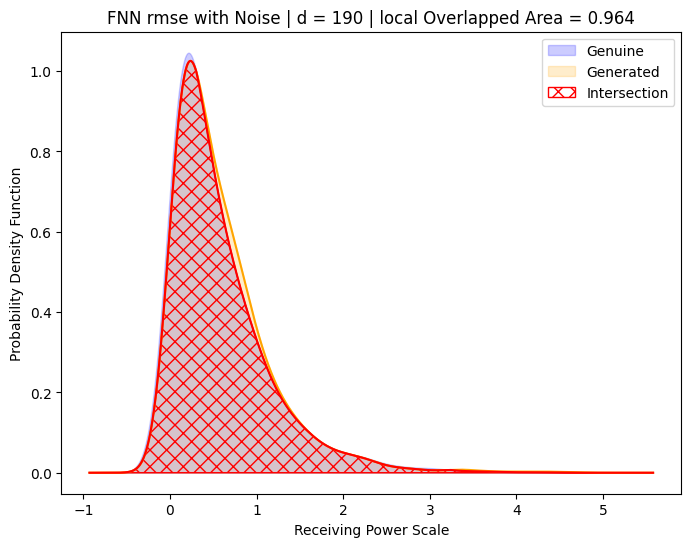

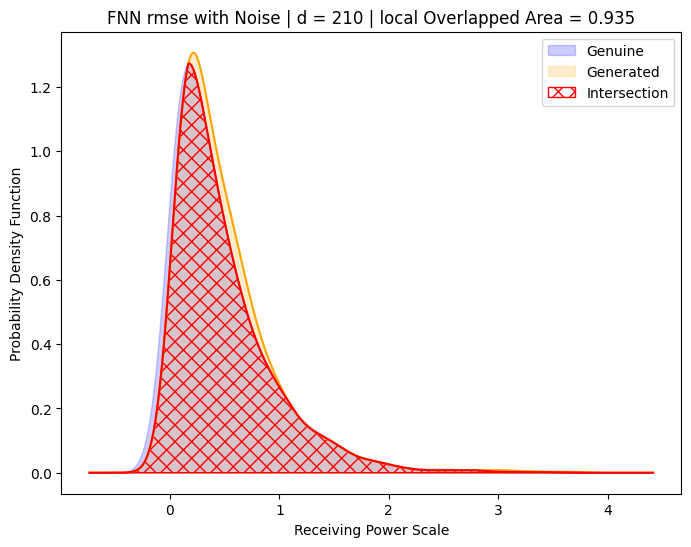

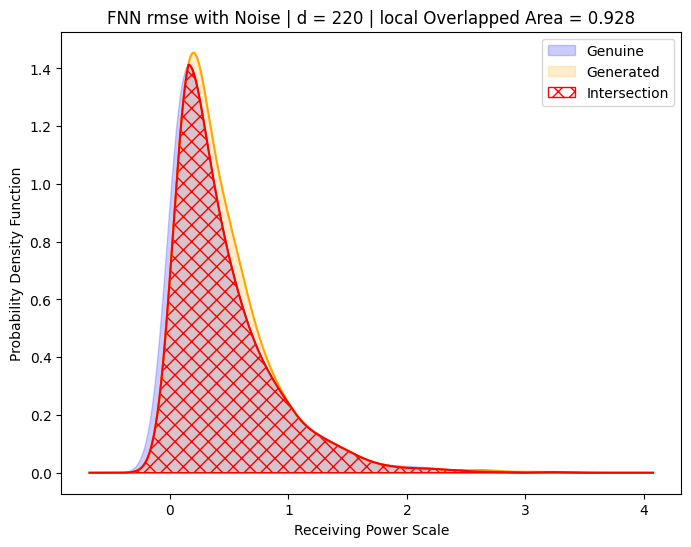

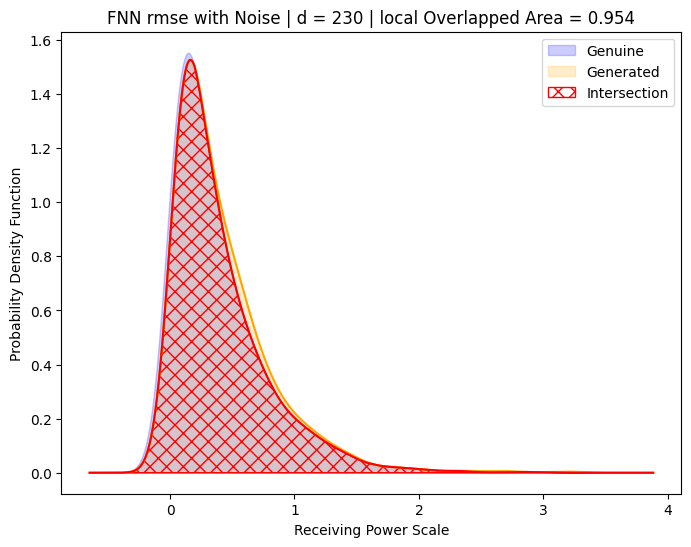

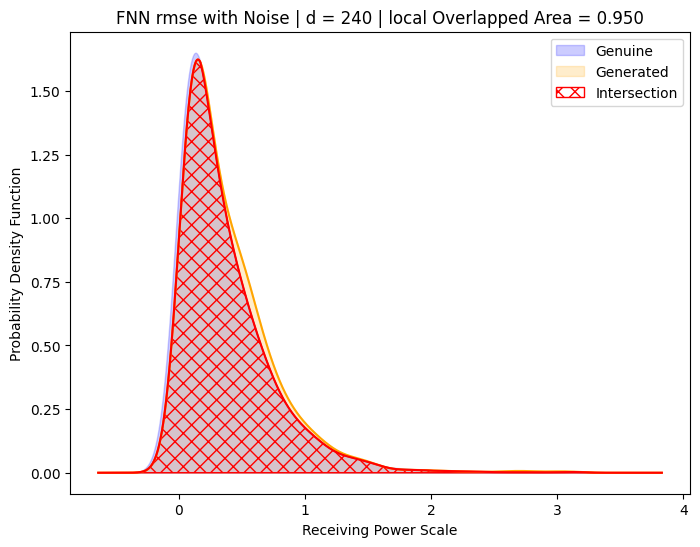

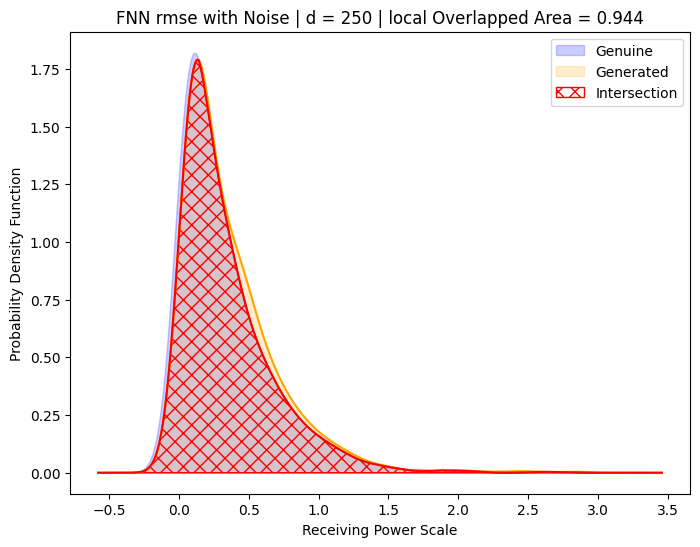

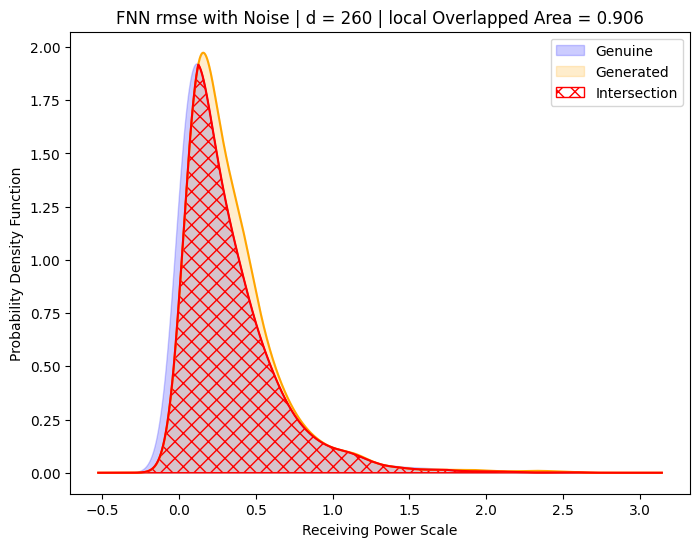

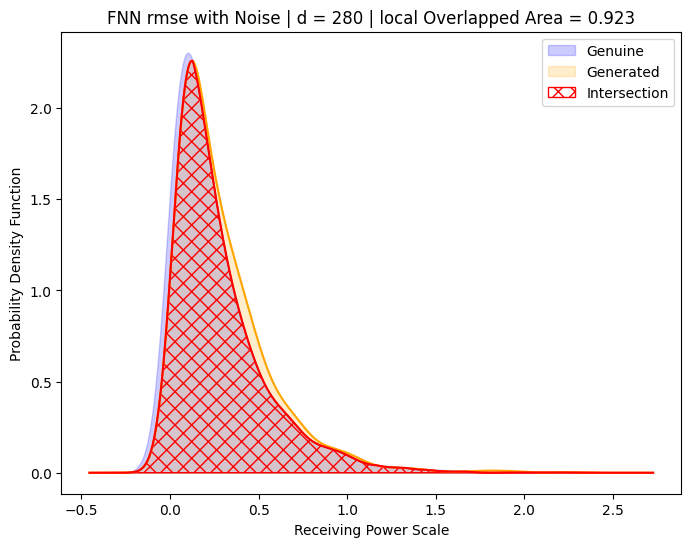

In [37]:
# https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

_d_array = np.arange(10, 301, 10, dtype=np.int32)
list_for_df = list()
for i in range(len(df_afterward_back_scaled['d'].unique())):
    # Melt the data to long-form
    fig, ax = plt.subplots(figsize=(8, 6))
    
    x0 = df_afterward_back_scaled[df_afterward_back_scaled['d'] == i]['genuine']
    x1 = df_afterward_back_scaled[df_afterward_back_scaled['d'] == i]['generated']

    kde0 = gaussian_kde(x0, bw_method=0.3)
    kde1 = gaussian_kde(x1, bw_method=0.3)
    
    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx
    
    x = np.linspace(xmin, xmax, len(x0))
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    plt.fill_between(x, kde0_x, 0, color='b', alpha=0.2, label='Genuine')
    plt.plot(x, kde1_x, color='orange')
    plt.fill_between(x, kde1_x, 0, color='orange', label='Generated', alpha=0.2)
    plt.plot(x, inters_x, color='r')
    plt.fill_between(x, inters_x, 0, facecolor='none', edgecolor='r', hatch='xx', label='Intersection')
    
    area_inters_x = np.trapz(inters_x, x)
    
    list_for_df.append([i, area_inters_x])
    ax.set_title(f"FNN rmse with Noise | d = {_d_array[i]} | local Overlapped Area = {area_inters_x:.3f}")
    plt.xlabel('Receiving Power Scale')
    plt.ylabel('Probability Density Function')
    legend = plt.legend()

    plt.show()

In [38]:
df_oa_back_scaled = pd.DataFrame(list_for_df, columns=['d', 'area_overlapped'])
print(f"Average Overlapped Area = {df_oa_back_scaled['area_overlapped'].mean()}")
df_oa_back_scaled

Average Overlapped Area = 0.9553149950778929


d  area_overlapped
0    0         0.953191
1    1         0.955218
2    2         0.960891
3    3         0.965929
4    4         0.965515
5    5         0.971353
6    6         0.970378
7    7         0.972641
8    8         0.973884
9    9         0.976537
10  10         0.981263
11  11         0.984239
12  12         0.985324
13  13         0.985995
14  14         0.967826
15  15         0.972071
16  16         0.957454
17  17         0.952491
18  18         0.963620
19  19         0.941592
20  20         0.935050
21  21         0.927886
22  22         0.954032
23  23         0.950387
24  24         0.943952
25  25         0.905594
26  26         0.933089
27  27         0.922853
28  28         0.917532
29  29         0.911665

### Generated Data Evalulation

#### Mean

In [39]:
df_mean_comp = pd.concat([df_afterward_back_scaled.groupby('d')['generated'].mean(), df_ideal_mean], axis=1)
df_per_diff_mean_real = (((df_mean_comp['generated'] - df_mean_comp['ideal_data']) / df_mean_comp['ideal_data']) * 100).round(2)
df_per_diff_mean_dict = {'per_diff%':df_per_diff_mean_real, }
df_mean_comp_final = pd.concat([df_mean_comp, pd.DataFrame(df_per_diff_mean_dict)], axis=1)
df_mean_comp_final

generated  ideal_data  per_diff%
0.0   191.152176  205.460011      -6.96
1.0    47.936516   51.365003      -6.67
2.0    21.246038   22.828890      -6.93
3.0    12.401963   12.841251      -3.42
4.0     7.727764    8.218400      -5.97
5.0     5.505378    5.707223      -3.54
6.0     4.108193    4.193061      -2.02
7.0     3.116455    3.210313      -2.92
8.0     2.459093    2.536543      -3.05
9.0     2.001382    2.054600      -2.59
10.0    1.684855    1.698017      -0.78
11.0    1.429625    1.426806       0.20
12.0    1.202734    1.215740      -1.07
13.0    1.042805    1.048265      -0.52
14.0    0.961168    0.913156       5.26
15.0    0.814308    0.802578       1.46
16.0    0.751398    0.710934       5.69
17.0    0.661671    0.634136       4.34
18.0    0.594695    0.569141       4.49
19.0    0.563676    0.513650       9.74
20.0    0.501754    0.465896       7.70
21.0    0.462233    0.424504       8.89
22.0    0.418575    0.388393       7.77
23.0    0.393807    0.356701      10.40
24.0    0.362764    0.328736      10.35
25.0    0.347922    0.303935      14.47
26.0    0.320831    0.281838      13.84
27.0    0.298176    0.262066      13.78
28.0    0.283760    0.244304      16.15
29.0    0.262721    0.228289      15.08

#### Variance

In [40]:
df_var_comp = pd.concat([df_afterward_back_scaled.groupby('d')['generated'].var(), df_ideal_var], axis=1)
df_per_diff_var_real = (((df_var_comp['generated'] - df_var_comp['ideal_data']) / df_var_comp['ideal_data']) * 100).round(2)
df_per_diff_var_dict = {'per_diff%':df_per_diff_var_real, }
df_var_comp_final = pd.concat([df_var_comp, pd.DataFrame(df_per_diff_var_dict)], axis=1)
df_var_comp_final

generated    ideal_data  per_diff%
0.0   20104.128906  21106.908132      -4.75
1.0    1314.961304   1319.181758      -0.32
2.0     237.202484    260.579113      -8.97
3.0      78.635162     82.448860      -4.63
4.0      30.753914     33.771053      -8.93
5.0      16.065447     16.286195      -1.36
6.0       9.177057      8.790882       4.39
7.0       5.105332      5.153054      -0.93
8.0       2.975291      3.217026      -7.51
9.0       2.026691      2.110691      -3.98
10.0      1.426546      1.441630      -1.05
11.0      1.020382      1.017887       0.25
12.0      0.703661      0.739012      -4.78
13.0      0.524818      0.549430      -4.48
14.0      0.875100      0.833853       4.95
15.0      0.668878      0.644132       3.84
16.0      0.540490      0.505428       6.94
17.0      0.373471      0.402128      -7.13
18.0      0.317361      0.323922      -2.03
19.0      0.281975      0.263836       6.88
20.0      0.208024      0.217059      -4.16
21.0      0.171544      0.180204      -4.81
22.0      0.154503      0.150849       2.42
23.0      0.136649      0.127236       7.40
24.0      0.116961      0.108067       8.23
25.0      0.093816      0.092376       1.56
26.0      0.080645      0.079433       1.53
27.0      0.071060      0.068679       3.47
28.0      0.062443      0.059685       4.62
29.0      0.051746      0.052116      -0.71